In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import torch

from torch import nn, distributions
import torch.optim as optim
from torch.utils.data import DataLoader
from scipy.stats import norm


# Create Dataset

Model:
$$
\theta_1 = 0, \theta_2 = 1, \sigma_x^2 =2 \\
\pi \sim Bernoulli(p=0.5) \\
x_i \sim \pi * N(\theta_1, \sigma_x^2) + (1-\pi) * N(\theta_1 + \theta_2, \sigma_x^2)
$$


NOTE: It looks like to get the multi-model behaviour, I have to use $\sigma_x^2 = 4$ NOT $\sigma_x^2 = 2$ like the paper suggests, most likely a bug in the paper or implementation.

In [2]:
def generate_dataset(theta1, theta2, x_std, N):
    return np.where(np.random.rand(N) >= 0.5, 
                    np.random.normal(theta1, x_std, N), 
                    np.random.normal(theta1 + theta2, x_std, N))


N = 100
theta1, theta2 = 0, 1
x_std = 1.60
np.random.seed(3)
data = generate_dataset(theta1, theta2, x_std, N)
data.shape

(100,)

<AxesSubplot:>

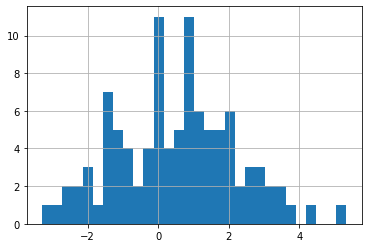

In [3]:
pd.Series(data).hist(bins=30)

# Exact Posterior (Brute Force)

In [4]:
# Make grid of all possible theta1 / theta2
mesh_N = 200
grid = np.meshgrid(np.linspace(-2, 2, mesh_N), np.linspace(-3, 3, mesh_N))
grid = np.stack(grid, axis=2)
grid.shape

(200, 200, 2)

In [5]:
# Compute log pdf of priors
logprob_theta1 = norm.logpdf(grid[:, :, 0], loc=0, scale=np.sqrt(10))
logprob_theta1.shape

logprob_theta2 = norm.logpdf(grid[:, :, 1], loc=0, scale=1)
logprob_theta2.shape

(200, 200)

In [6]:
# Compute log likelihood
# theta1 + theta2 | theta1 ~ N(theta1, sigma2)
log_likelihood = np.zeros(logprob_theta1.shape)
for i, d in enumerate(data):
    prob_x = (0.5 * norm.pdf(d, loc=grid[:, :, 0], scale=np.sqrt(2)) +
              0.5 * norm.pdf(d, loc=grid.sum(axis=2), scale=np.sqrt(2)))
    log_likelihood += np.log(prob_x)

# Normalize log posterior by constant to make it friendlier for np.exp(.) 
unnormalized_log_posterior = log_likelihood + logprob_theta1 + logprob_theta2
log_posterior = unnormalized_log_posterior - unnormalized_log_posterior.max()
posterior = np.exp(log_posterior)
posterior.shape

(200, 200)

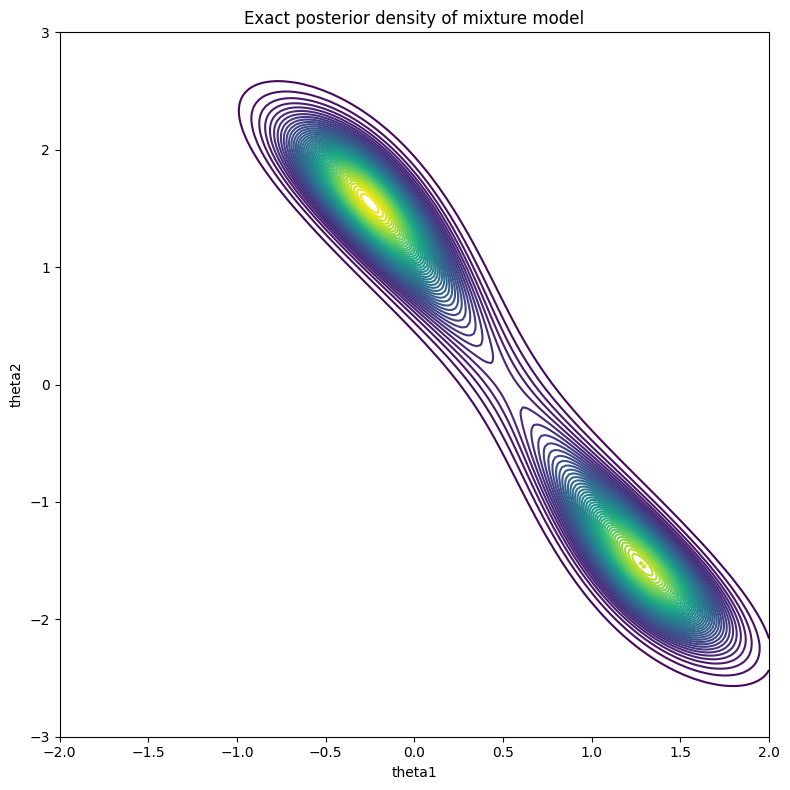

In [7]:
plt.figure(figsize=(8, 8), dpi=100)
xlim = (-2, 2)
ylim = (-3, 3)
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.contour(grid[:, :, 0], grid[:, :, 1], posterior, 
            #extent=xlim+ylim, 
            levels=50)
plt.title('Exact posterior density of mixture model')
plt.xlabel('theta1')
plt.ylabel('theta2')
plt.tight_layout()

# MCMC

Model:
$$
\theta_1 \sim N(0, \sigma_1^2=10) \\
\theta_2 \sim N(0, \sigma_2^2=1) \\
\pi \sim Bernoulli(p=0.5) \\
x_i \sim \pi * N(\theta_1, \sigma_x^2=2) + (1-\pi) * N(\theta_1 + \theta_2, \sigma_x^2=2) \\
$$

In [8]:
with pm.Model() as model:
    theta1 = pm.Normal("theta1", mu=0, sigma=np.sqrt(10))
    theta2 = pm.Normal("theta2", mu=0, sigma=1)
    obs = pm.NormalMixture("obs", w=[0.5, 0.5], 
                           mu=[theta1, theta1 + theta2], 
                           sigma=[np.sqrt(2), np.sqrt(2)], 
                           observed=data)

    idata = pm.sample(5000, chains=1, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [theta1, theta2]


Sampling 1 chain for 2_000 tune and 5_000 draw iterations (2_000 + 5_000 draws total) took 11 seconds.
The acceptance probability does not match the target. It is 0.9045, but should be close to 0.8. Try to increase the number of tuning steps.


In [9]:
df_mcmc = pd.DataFrame({'theta1': idata.posterior['theta1'][0],
                        'theta2': idata.posterior['theta2'][0]})

df_mcmc.describe()

,theta1,theta2
count,5000.000000,5000.000000
mean,0.545013,-0.059138
std,0.770902,1.517224
min,-1.237823,-2.786443
25%,-0.200012,-1.488365
50%,0.743183,-0.498521
75%,1.251378,1.468476
max,2.134823,2.904636


<AxesSubplot:>

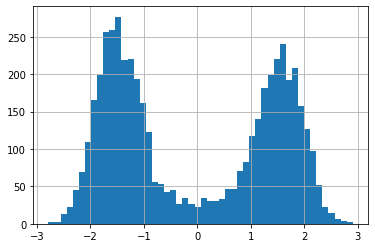

In [10]:
df_mcmc['theta2'].hist(bins=50)

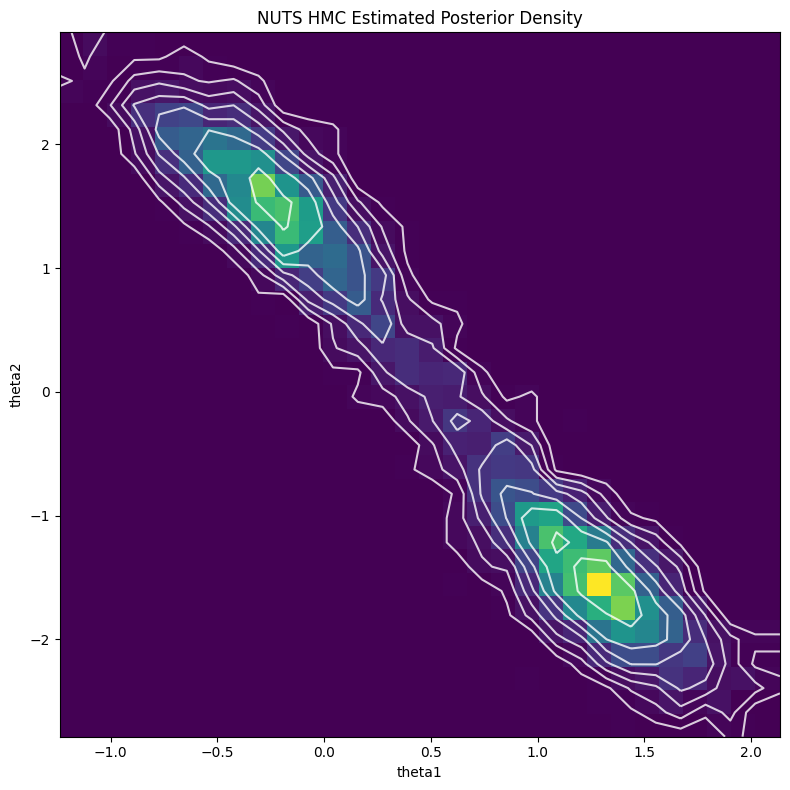

In [11]:
X, Y = df_mcmc.transpose().values
X, Y
plt.figure(figsize=(8, 8), dpi=100).set_facecolor('white')
h, xs, ys, image = plt.hist2d(X, Y, bins=[30, 30])
plt.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
            colors='white', alpha=0.8)
plt.title('NUTS HMC Estimated Posterior Density')
plt.xlabel('theta1')
plt.ylabel('theta2')
plt.tight_layout()

<AxesSubplot:title={'center':'NUTS HMC Samples (PyMC)'}, xlabel='theta1', ylabel='theta2'>

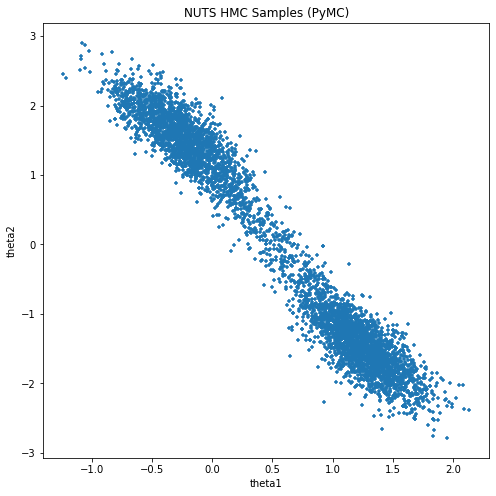

In [12]:
df_mcmc.plot.scatter(x=0, y=1, marker='+', 
                     #xlim=xlim, ylim=ylim,
                     figsize=(8,8),
                title='NUTS HMC Samples (PyMC)')

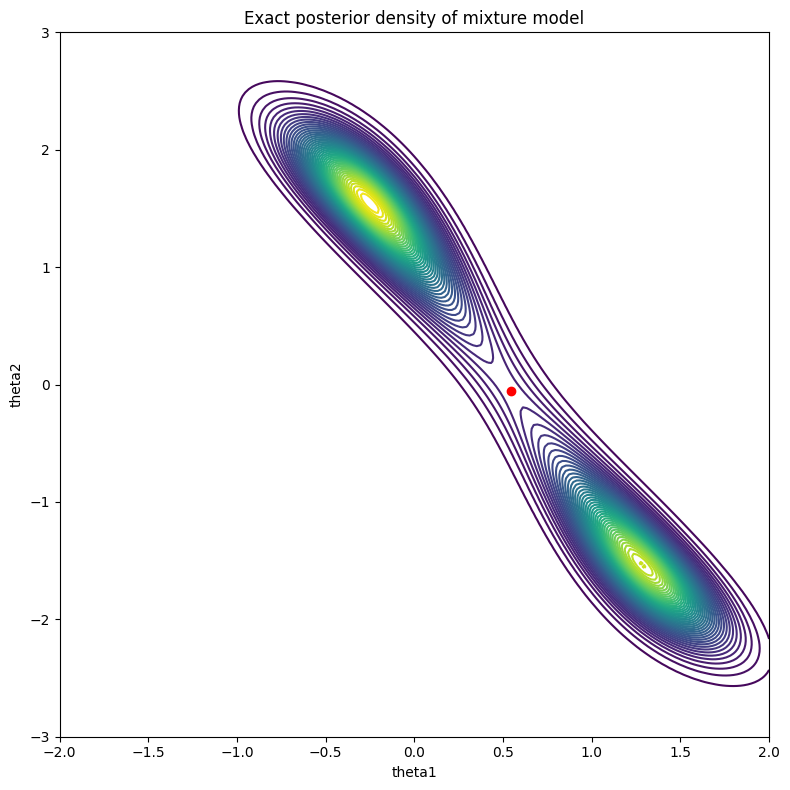

In [13]:
plt.figure(figsize=(8, 8), dpi=100)
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.contour(grid[:, :, 0], grid[:, :, 1], posterior, 
            extent=xlim+ylim, 
            levels=50)
plt.title('Exact posterior density of mixture model')
plt.xlabel('theta1')
plt.ylabel('theta2')
plt.plot(df_mcmc['theta1'].mean(), df_mcmc['theta2'].mean(), 'ro') 
plt.tight_layout()

# Stochastic Gradient Langevin Dynamics

Model:
$$
\theta_1 \sim N(0, \sigma_1^2=10) \\
\theta_2 \sim N(0, \sigma_2^2=1) \\
\pi \sim Bernoulli(p=0.5) \\
x_i \sim \pi * N(\theta_1, \sigma_x^2=2) + (1-\pi) * N(\theta_1 + \theta_2, \sigma_x^2=2) \\
\\
\text{Note: } \theta_1+\theta_2|\theta_1 \sim N(\theta_1, \sigma_2^2)
$$

In [14]:
class MixtureModel(nn.Module):
    def __init__(self, theta1_var, theta2_var, x_var):
        super(MixtureModel, self).__init__()
        self.theta1_var = theta1_var
        self.theta2_var = theta2_var
        self.x_std = torch.sqrt(x_var)
        self.theta = nn.Parameter(torch.ones(2))

    def forward(self):
        mean1 = self.theta[0]
        mean2 = self.theta.sum()
        mixture_means = torch.cat([torch.unsqueeze(mean1, 0), torch.unsqueeze(mean2, 0)])
        return mixture_means

    def _gmm(self, mixture_means):
        mix = distributions.Categorical(torch.ones(2,))
        comp = distributions.Normal(loc=mixture_means, scale=torch.tensor([self.x_std, self.x_std]))
        return distributions.MixtureSameFamily(mix, comp)
   
    def loss(self, mixture_means, batch_data, N):
        log_likelihood = - N / len(batch_data) * self._gmm(mixture_means).log_prob(batch_data).sum()
        log_prior = (torch.nn.functional.gaussian_nll_loss(torch.zeros(1),  self.theta[0], self.theta1_var)
                     + torch.nn.functional.gaussian_nll_loss(torch.zeros(1),  self.theta[1], self.theta2_var))
        return log_likelihood + log_prior

In [15]:
class MixtureDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        super(MixtureDataset).__init__()
        self.data = torch.tensor(data)
        
    def __len__(self):
        return len(data)

    def __getitem__(self, idx):
        return data[idx]

batch_size = 100
mixture_dataset = MixtureDataset(data)
train_dataloader = DataLoader(mixture_dataset, batch_size=batch_size, shuffle=True)

## Regular Stochastic Gradient Descent

In [16]:
torch_model = MixtureModel(theta1_var=torch.tensor(10.),
                           theta2_var=torch.tensor(1.),
                           x_var=torch.tensor(2.))
optimizer = optim.SGD(torch_model.parameters(), lr=0.01)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5)

print(data.mean())
epoch = 0
for epoch in range(300):
    running_loss = 0.
    for i, batch_data in enumerate(train_dataloader, 0):
        torch_model.zero_grad()

        mixture_means = torch_model()
        theta = torch_model.theta
        loss = torch_model.loss(mixture_means, batch_data, len(data))
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    lr_scheduler.step(running_loss)
    if epoch % 10 == 9:
        print(f'[{epoch+1}, {i+1}] loss: {running_loss:.5f}')
        
parameters = next(torch_model.parameters())
parameters

0.5192015550409603
[10, 1] loss: 197.83314
[20, 1] loss: 197.46960
[30, 1] loss: 197.18312
[40, 1] loss: 196.99635
[50, 1] loss: 196.89120
[60, 1] loss: 196.83790
[70, 1] loss: 196.81274
[80, 1] loss: 196.80141
[90, 1] loss: 196.79821
[100, 1] loss: 196.79700
[110, 1] loss: 196.79647
[120, 1] loss: 196.79621
[130, 1] loss: 196.79607
[140, 1] loss: 196.79601
[150, 1] loss: 196.79597
[160, 1] loss: 196.79595
[170, 1] loss: 196.79594
[180, 1] loss: 196.79594
[190, 1] loss: 196.79593
[200, 1] loss: 196.79593
[210, 1] loss: 196.79593
[220, 1] loss: 196.79593
[230, 1] loss: 196.79593
[240, 1] loss: 196.79593
[250, 1] loss: 196.79593
[260, 1] loss: 196.79593
[270, 1] loss: 196.79593
[280, 1] loss: 196.79593
[290, 1] loss: 196.79593
[300, 1] loss: 196.79593


Parameter containing:
tensor([-0.2327,  1.5129], requires_grad=True)

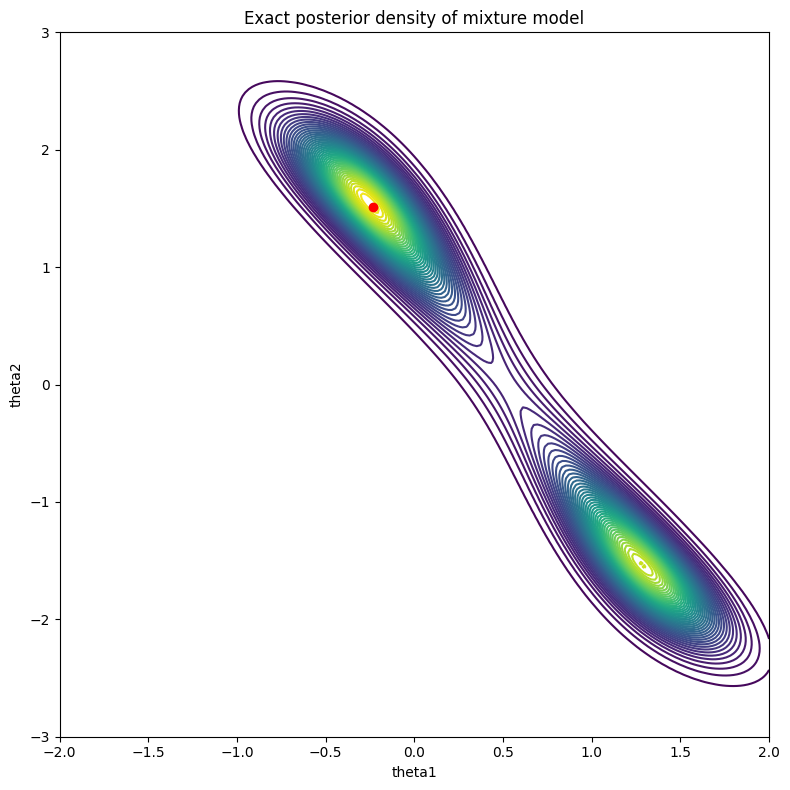

In [17]:
plt.figure(figsize=(8, 8), dpi=100)
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.contour(grid[:, :, 0], grid[:, :, 1], posterior, 
            extent=xlim+ylim, 
            levels=50)
plt.title('Exact posterior density of mixture model')
plt.xlabel('theta1')
plt.ylabel('theta2')
plt.plot(parameters[0].item(), parameters[1].item(), 'ro') 
plt.tight_layout()

## Stochastic Gradient Langevin Dynamics

In [18]:
def compute_lr(t, start=0.01, end=0.0001):
    gamma = 0.55
    b = 1e4 * len(data) / batch_size / ((end / start) ** (-1/gamma) - 1) 
    a = start * (b ** gamma)
    return a * ((b + t) ** (-gamma))

print(f't=0:     {compute_lr(0):4f}\nt=10000: {compute_lr(10000 * 1 ):4f}')
print(f't=0:     {compute_lr(0):4f}\nt=100000: {compute_lr(10000 * 10):4f}')
print(f't=0:     {compute_lr(0):4f}\nt=1000000: {compute_lr(10000 * 100):4f}')

t=0:     0.010000
t=10000: 0.000100
t=0:     0.010000
t=100000: 0.000028
t=0:     0.010000
t=1000000: 0.000008


In [19]:
compute_lr(0, 0.01, 0.0001)

0.01

In [20]:
def sample_sgld(batch_size, lr_start=0.01, lr_end=0.0001):
    mixture_dataset = MixtureDataset(data)
    train_dataloader = DataLoader(mixture_dataset, batch_size=batch_size, shuffle=True)
    
    torch_model = MixtureModel(theta1_var=torch.tensor(10.), 
                               theta2_var=torch.tensor(1.), 
                               x_var=torch.tensor(2.))
    
    lr = compute_lr(0)
    samples = []
    
    num_epochs = 10000 * batch_size
    for epoch in range(num_epochs):
        running_loss = 0.
        for i, batch_data in enumerate(train_dataloader, 0):
            torch_model.zero_grad()
          
            mixture_means = torch_model()
            theta = torch_model.theta
            loss = torch_model.loss(mixture_means, batch_data, len(data))
            loss.backward()
           
            with torch.no_grad():
                for p in torch_model.parameters():
                    noise = torch.squeeze(torch.normal(mean=0., std=np.sqrt(lr), size=(2,)))
                    grad = 0.5 * lr * p.grad + noise
                    p.copy_(p - grad)
                    
            running_loss += loss.item()
            lr = compute_lr(len(train_dataloader) * epoch + i, start=lr_start, end=lr_end)
            
            samples.append([theta[0].item() for x in torch_model.parameters()] 
                           + [theta[1].item() for x in torch_model.parameters()]
                           + [lr])
        
        if epoch % 100 == 99:
            print(f'[{epoch+1}] loss: {running_loss:.3f}, lr: {lr:.5f}')
    
    return samples

In [21]:
samples = {}
df_sgld = {}
for batch_size, lr_start, lr_end in [(100, 0.01, 0.001), (10, 0.01, 0.0001), (1, 0.01, 0.0001)]:
    print(f'============== {batch_size} =============')
    samples[batch_size] = sample_sgld(batch_size, lr_start, lr_end)
    df_sgld[batch_size] = pd.DataFrame(samples[batch_size], columns=['theta1', 'theta2', 'eps'])
    
for batch_size in [100, 10, 1]:
    print(f'============== {batch_size} =============')
    display(df_sgld[batch_size].describe())
    theta1_adj_mean = (df_sgld[batch_size]['theta1'] * df_sgld[batch_size]['eps']).sum() / df_sgld[batch_size]['eps'].sum()
    theta2_adj_mean = (df_sgld[batch_size]['theta2'] * df_sgld[batch_size]['eps']).sum() / df_sgld[batch_size]['eps'].sum()
    print(f'Adjusted means:\n * theta1: {theta1_adj_mean}\n * theta2: {theta2_adj_mean}')

============== 100 =============
[100] loss: 199.050, lr: 0.00761
[200] loss: 197.580, lr: 0.00634
[300] loss: 198.103, lr: 0.00553
[400] loss: 197.207, lr: 0.00495
[500] loss: 196.892, lr: 0.00452
[600] loss: 198.158, lr: 0.00418
[700] loss: 197.812, lr: 0.00390
[800] loss: 197.074, lr: 0.00367
[900] loss: 197.156, lr: 0.00348
[1000] loss: 197.658, lr: 0.00331
[1100] loss: 197.111, lr: 0.00316
[1200] loss: 197.656, lr: 0.00303
[1300] loss: 196.888, lr: 0.00291
[1400] loss: 197.366, lr: 0.00281
[1500] loss: 198.549, lr: 0.00271
[1600] loss: 198.034, lr: 0.00263
[1700] loss: 197.514, lr: 0.00255
[1800] loss: 198.563, lr: 0.00248
[1900] loss: 197.241, lr: 0.00241
[2000] loss: 196.903, lr: 0.00235
[2100] loss: 197.845, lr: 0.00229
[2200] loss: 198.676, lr: 0.00223
[2300] loss: 200.425, lr: 0.00218
[2400] loss: 197.767, lr: 0.00214
[2500] loss: 196.809, lr: 0.00209
[2600] loss: 197.125, lr: 0.00205
[2700] loss: 196.938, lr: 0.00201
[2800] loss: 196.883, lr: 0.00197
[2900] loss: 197.423, lr

[23800] loss: 199.618, lr: 0.00062
[23900] loss: 198.947, lr: 0.00062
[24000] loss: 199.745, lr: 0.00062
[24100] loss: 199.839, lr: 0.00062
[24200] loss: 198.979, lr: 0.00062
[24300] loss: 198.938, lr: 0.00062
[24400] loss: 200.334, lr: 0.00062
[24500] loss: 198.792, lr: 0.00061
[24600] loss: 199.007, lr: 0.00061
[24700] loss: 198.993, lr: 0.00061
[24800] loss: 199.003, lr: 0.00061
[24900] loss: 198.886, lr: 0.00061
[25000] loss: 198.959, lr: 0.00061
[25100] loss: 198.967, lr: 0.00061
[25200] loss: 200.034, lr: 0.00060
[25300] loss: 199.119, lr: 0.00060
[25400] loss: 199.973, lr: 0.00060
[25500] loss: 198.155, lr: 0.00060
[25600] loss: 197.441, lr: 0.00060
[25700] loss: 197.380, lr: 0.00060
[25800] loss: 198.039, lr: 0.00060
[25900] loss: 200.513, lr: 0.00060
[26000] loss: 198.254, lr: 0.00059
[26100] loss: 201.056, lr: 0.00059
[26200] loss: 196.913, lr: 0.00059
[26300] loss: 196.840, lr: 0.00059
[26400] loss: 198.705, lr: 0.00059
[26500] loss: 197.355, lr: 0.00059
[26600] loss: 199.05

[47400] loss: 197.269, lr: 0.00043
[47500] loss: 198.110, lr: 0.00043
[47600] loss: 197.616, lr: 0.00043
[47700] loss: 197.828, lr: 0.00043
[47800] loss: 197.114, lr: 0.00043
[47900] loss: 199.632, lr: 0.00043
[48000] loss: 198.604, lr: 0.00042
[48100] loss: 198.712, lr: 0.00042
[48200] loss: 198.621, lr: 0.00042
[48300] loss: 198.540, lr: 0.00042
[48400] loss: 197.531, lr: 0.00042
[48500] loss: 197.024, lr: 0.00042
[48600] loss: 197.000, lr: 0.00042
[48700] loss: 198.083, lr: 0.00042
[48800] loss: 197.913, lr: 0.00042
[48900] loss: 201.230, lr: 0.00042
[49000] loss: 199.236, lr: 0.00042
[49100] loss: 197.842, lr: 0.00042
[49200] loss: 197.382, lr: 0.00042
[49300] loss: 197.501, lr: 0.00042
[49400] loss: 200.001, lr: 0.00042
[49500] loss: 197.694, lr: 0.00042
[49600] loss: 198.134, lr: 0.00042
[49700] loss: 197.867, lr: 0.00042
[49800] loss: 198.088, lr: 0.00042
[49900] loss: 196.947, lr: 0.00042
[50000] loss: 197.701, lr: 0.00042
[50100] loss: 197.072, lr: 0.00041
[50200] loss: 196.95

[70900] loss: 197.262, lr: 0.00034
[71000] loss: 196.895, lr: 0.00034
[71100] loss: 196.832, lr: 0.00034
[71200] loss: 197.084, lr: 0.00034
[71300] loss: 196.935, lr: 0.00034
[71400] loss: 198.071, lr: 0.00034
[71500] loss: 197.250, lr: 0.00034
[71600] loss: 197.053, lr: 0.00034
[71700] loss: 196.891, lr: 0.00034
[71800] loss: 196.849, lr: 0.00034
[71900] loss: 196.879, lr: 0.00034
[72000] loss: 197.133, lr: 0.00034
[72100] loss: 200.359, lr: 0.00034
[72200] loss: 202.058, lr: 0.00034
[72300] loss: 202.945, lr: 0.00034
[72400] loss: 197.958, lr: 0.00034
[72500] loss: 197.692, lr: 0.00034
[72600] loss: 198.477, lr: 0.00034
[72700] loss: 198.234, lr: 0.00034
[72800] loss: 198.275, lr: 0.00034
[72900] loss: 198.374, lr: 0.00034
[73000] loss: 197.969, lr: 0.00034
[73100] loss: 198.395, lr: 0.00034
[73200] loss: 198.223, lr: 0.00034
[73300] loss: 197.795, lr: 0.00034
[73400] loss: 198.373, lr: 0.00034
[73500] loss: 198.923, lr: 0.00034
[73600] loss: 199.126, lr: 0.00034
[73700] loss: 199.49

[94500] loss: 197.058, lr: 0.00029
[94600] loss: 197.298, lr: 0.00029
[94700] loss: 198.012, lr: 0.00029
[94800] loss: 197.196, lr: 0.00029
[94900] loss: 196.814, lr: 0.00029
[95000] loss: 197.231, lr: 0.00029
[95100] loss: 197.066, lr: 0.00029
[95200] loss: 196.981, lr: 0.00029
[95300] loss: 197.590, lr: 0.00029
[95400] loss: 198.018, lr: 0.00029
[95500] loss: 198.301, lr: 0.00029
[95600] loss: 196.826, lr: 0.00029
[95700] loss: 197.020, lr: 0.00029
[95800] loss: 197.280, lr: 0.00029
[95900] loss: 197.185, lr: 0.00029
[96000] loss: 197.556, lr: 0.00029
[96100] loss: 196.901, lr: 0.00029
[96200] loss: 197.168, lr: 0.00029
[96300] loss: 197.446, lr: 0.00029
[96400] loss: 197.660, lr: 0.00029
[96500] loss: 200.296, lr: 0.00029
[96600] loss: 197.116, lr: 0.00029
[96700] loss: 197.027, lr: 0.00029
[96800] loss: 196.845, lr: 0.00029
[96900] loss: 197.590, lr: 0.00029
[97000] loss: 197.454, lr: 0.00029
[97100] loss: 199.263, lr: 0.00029
[97200] loss: 197.653, lr: 0.00029
[97300] loss: 197.85

[117500] loss: 196.816, lr: 0.00026
[117600] loss: 196.926, lr: 0.00026
[117700] loss: 198.194, lr: 0.00026
[117800] loss: 199.428, lr: 0.00026
[117900] loss: 197.791, lr: 0.00026
[118000] loss: 197.595, lr: 0.00026
[118100] loss: 198.421, lr: 0.00026
[118200] loss: 198.605, lr: 0.00026
[118300] loss: 198.759, lr: 0.00026
[118400] loss: 199.123, lr: 0.00026
[118500] loss: 199.097, lr: 0.00026
[118600] loss: 197.851, lr: 0.00026
[118700] loss: 197.925, lr: 0.00026
[118800] loss: 197.584, lr: 0.00026
[118900] loss: 197.493, lr: 0.00026
[119000] loss: 197.663, lr: 0.00026
[119100] loss: 197.587, lr: 0.00026
[119200] loss: 196.965, lr: 0.00026
[119300] loss: 196.818, lr: 0.00026
[119400] loss: 197.578, lr: 0.00026
[119500] loss: 197.029, lr: 0.00026
[119600] loss: 196.955, lr: 0.00026
[119700] loss: 197.239, lr: 0.00026
[119800] loss: 198.292, lr: 0.00026
[119900] loss: 197.730, lr: 0.00026
[120000] loss: 197.217, lr: 0.00026
[120100] loss: 198.913, lr: 0.00026
[120200] loss: 199.669, lr: 

[140300] loss: 202.085, lr: 0.00024
[140400] loss: 200.112, lr: 0.00024
[140500] loss: 199.872, lr: 0.00024
[140600] loss: 199.655, lr: 0.00024
[140700] loss: 199.098, lr: 0.00024
[140800] loss: 200.141, lr: 0.00024
[140900] loss: 198.841, lr: 0.00024
[141000] loss: 199.536, lr: 0.00024
[141100] loss: 200.173, lr: 0.00024
[141200] loss: 199.225, lr: 0.00023
[141300] loss: 200.935, lr: 0.00023
[141400] loss: 200.336, lr: 0.00023
[141500] loss: 200.584, lr: 0.00023
[141600] loss: 201.205, lr: 0.00023
[141700] loss: 201.107, lr: 0.00023
[141800] loss: 200.952, lr: 0.00023
[141900] loss: 200.461, lr: 0.00023
[142000] loss: 199.533, lr: 0.00023
[142100] loss: 198.388, lr: 0.00023
[142200] loss: 199.302, lr: 0.00023
[142300] loss: 199.004, lr: 0.00023
[142400] loss: 199.197, lr: 0.00023
[142500] loss: 198.861, lr: 0.00023
[142600] loss: 198.349, lr: 0.00023
[142700] loss: 198.281, lr: 0.00023
[142800] loss: 197.749, lr: 0.00023
[142900] loss: 198.171, lr: 0.00023
[143000] loss: 197.211, lr: 

[163100] loss: 198.854, lr: 0.00022
[163200] loss: 198.450, lr: 0.00022
[163300] loss: 198.134, lr: 0.00022
[163400] loss: 197.974, lr: 0.00022
[163500] loss: 197.781, lr: 0.00022
[163600] loss: 197.908, lr: 0.00022
[163700] loss: 197.596, lr: 0.00022
[163800] loss: 197.415, lr: 0.00022
[163900] loss: 196.987, lr: 0.00022
[164000] loss: 197.297, lr: 0.00022
[164100] loss: 196.997, lr: 0.00022
[164200] loss: 197.840, lr: 0.00022
[164300] loss: 197.060, lr: 0.00022
[164400] loss: 197.287, lr: 0.00022
[164500] loss: 197.042, lr: 0.00022
[164600] loss: 197.250, lr: 0.00022
[164700] loss: 197.121, lr: 0.00022
[164800] loss: 196.837, lr: 0.00022
[164900] loss: 196.860, lr: 0.00022
[165000] loss: 197.164, lr: 0.00022
[165100] loss: 197.005, lr: 0.00022
[165200] loss: 197.238, lr: 0.00022
[165300] loss: 197.537, lr: 0.00022
[165400] loss: 197.232, lr: 0.00022
[165500] loss: 197.733, lr: 0.00022
[165600] loss: 197.781, lr: 0.00022
[165700] loss: 199.614, lr: 0.00022
[165800] loss: 198.742, lr: 

[185900] loss: 197.393, lr: 0.00020
[186000] loss: 198.400, lr: 0.00020
[186100] loss: 199.125, lr: 0.00020
[186200] loss: 199.888, lr: 0.00020
[186300] loss: 199.751, lr: 0.00020
[186400] loss: 198.388, lr: 0.00020
[186500] loss: 197.204, lr: 0.00020
[186600] loss: 197.229, lr: 0.00020
[186700] loss: 197.837, lr: 0.00020
[186800] loss: 197.618, lr: 0.00020
[186900] loss: 197.360, lr: 0.00020
[187000] loss: 197.539, lr: 0.00020
[187100] loss: 197.056, lr: 0.00020
[187200] loss: 197.016, lr: 0.00020
[187300] loss: 197.723, lr: 0.00020
[187400] loss: 197.766, lr: 0.00020
[187500] loss: 197.291, lr: 0.00020
[187600] loss: 197.150, lr: 0.00020
[187700] loss: 197.015, lr: 0.00020
[187800] loss: 197.265, lr: 0.00020
[187900] loss: 196.919, lr: 0.00020
[188000] loss: 196.884, lr: 0.00020
[188100] loss: 197.176, lr: 0.00020
[188200] loss: 197.177, lr: 0.00020
[188300] loss: 197.242, lr: 0.00020
[188400] loss: 197.320, lr: 0.00020
[188500] loss: 196.931, lr: 0.00020
[188600] loss: 199.029, lr: 

[208700] loss: 196.971, lr: 0.00019
[208800] loss: 197.178, lr: 0.00019
[208900] loss: 197.387, lr: 0.00019
[209000] loss: 197.543, lr: 0.00019
[209100] loss: 197.194, lr: 0.00019
[209200] loss: 198.068, lr: 0.00019
[209300] loss: 197.265, lr: 0.00019
[209400] loss: 197.846, lr: 0.00019
[209500] loss: 197.199, lr: 0.00019
[209600] loss: 197.072, lr: 0.00019
[209700] loss: 196.910, lr: 0.00019
[209800] loss: 197.028, lr: 0.00019
[209900] loss: 197.558, lr: 0.00019
[210000] loss: 197.439, lr: 0.00019
[210100] loss: 196.994, lr: 0.00019
[210200] loss: 197.958, lr: 0.00019
[210300] loss: 197.651, lr: 0.00019
[210400] loss: 197.000, lr: 0.00019
[210500] loss: 197.278, lr: 0.00019
[210600] loss: 197.634, lr: 0.00019
[210700] loss: 199.233, lr: 0.00019
[210800] loss: 197.469, lr: 0.00019
[210900] loss: 198.176, lr: 0.00019
[211000] loss: 197.979, lr: 0.00019
[211100] loss: 198.362, lr: 0.00019
[211200] loss: 197.380, lr: 0.00019
[211300] loss: 197.378, lr: 0.00019
[211400] loss: 197.390, lr: 

[231500] loss: 198.828, lr: 0.00018
[231600] loss: 198.213, lr: 0.00018
[231700] loss: 198.444, lr: 0.00018
[231800] loss: 199.659, lr: 0.00018
[231900] loss: 199.977, lr: 0.00018
[232000] loss: 198.908, lr: 0.00018
[232100] loss: 198.734, lr: 0.00018
[232200] loss: 199.169, lr: 0.00018
[232300] loss: 198.403, lr: 0.00018
[232400] loss: 198.101, lr: 0.00018
[232500] loss: 197.838, lr: 0.00018
[232600] loss: 197.597, lr: 0.00018
[232700] loss: 197.650, lr: 0.00018
[232800] loss: 197.533, lr: 0.00018
[232900] loss: 197.631, lr: 0.00018
[233000] loss: 197.245, lr: 0.00018
[233100] loss: 197.392, lr: 0.00018
[233200] loss: 197.523, lr: 0.00018
[233300] loss: 198.977, lr: 0.00018
[233400] loss: 199.910, lr: 0.00018
[233500] loss: 199.203, lr: 0.00018
[233600] loss: 199.914, lr: 0.00018
[233700] loss: 199.072, lr: 0.00018
[233800] loss: 198.130, lr: 0.00018
[233900] loss: 197.620, lr: 0.00018
[234000] loss: 198.616, lr: 0.00018
[234100] loss: 197.722, lr: 0.00018
[234200] loss: 198.524, lr: 

[254300] loss: 197.268, lr: 0.00017
[254400] loss: 197.057, lr: 0.00017
[254500] loss: 197.850, lr: 0.00017
[254600] loss: 197.693, lr: 0.00017
[254700] loss: 198.273, lr: 0.00017
[254800] loss: 197.512, lr: 0.00017
[254900] loss: 197.647, lr: 0.00017
[255000] loss: 197.113, lr: 0.00017
[255100] loss: 197.032, lr: 0.00017
[255200] loss: 197.087, lr: 0.00017
[255300] loss: 197.261, lr: 0.00017
[255400] loss: 197.260, lr: 0.00017
[255500] loss: 196.970, lr: 0.00017
[255600] loss: 196.987, lr: 0.00017
[255700] loss: 198.854, lr: 0.00017
[255800] loss: 197.795, lr: 0.00017
[255900] loss: 197.667, lr: 0.00017
[256000] loss: 198.303, lr: 0.00017
[256100] loss: 198.062, lr: 0.00017
[256200] loss: 197.529, lr: 0.00017
[256300] loss: 197.720, lr: 0.00017
[256400] loss: 197.591, lr: 0.00017
[256500] loss: 197.380, lr: 0.00017
[256600] loss: 196.994, lr: 0.00017
[256700] loss: 197.080, lr: 0.00017
[256800] loss: 197.497, lr: 0.00017
[256900] loss: 197.491, lr: 0.00017
[257000] loss: 197.411, lr: 

[277200] loss: 196.992, lr: 0.00016
[277300] loss: 197.285, lr: 0.00016
[277400] loss: 197.313, lr: 0.00016
[277500] loss: 197.649, lr: 0.00016
[277600] loss: 197.311, lr: 0.00016
[277700] loss: 197.314, lr: 0.00016
[277800] loss: 197.399, lr: 0.00016
[277900] loss: 197.443, lr: 0.00016
[278000] loss: 198.288, lr: 0.00016
[278100] loss: 199.316, lr: 0.00016
[278200] loss: 197.577, lr: 0.00016
[278300] loss: 197.466, lr: 0.00016
[278400] loss: 197.176, lr: 0.00016
[278500] loss: 196.912, lr: 0.00016
[278600] loss: 197.002, lr: 0.00016
[278700] loss: 197.198, lr: 0.00016
[278800] loss: 196.913, lr: 0.00016
[278900] loss: 196.908, lr: 0.00016
[279000] loss: 197.905, lr: 0.00016
[279100] loss: 198.179, lr: 0.00016
[279200] loss: 197.162, lr: 0.00016
[279300] loss: 197.246, lr: 0.00016
[279400] loss: 197.581, lr: 0.00016
[279500] loss: 196.965, lr: 0.00016
[279600] loss: 197.967, lr: 0.00016
[279700] loss: 197.943, lr: 0.00016
[279800] loss: 197.090, lr: 0.00016
[279900] loss: 196.963, lr: 

[300000] loss: 196.888, lr: 0.00016
[300100] loss: 197.028, lr: 0.00016
[300200] loss: 197.146, lr: 0.00016
[300300] loss: 197.568, lr: 0.00016
[300400] loss: 197.193, lr: 0.00016
[300500] loss: 197.396, lr: 0.00016
[300600] loss: 198.061, lr: 0.00016
[300700] loss: 197.739, lr: 0.00016
[300800] loss: 198.887, lr: 0.00016
[300900] loss: 198.255, lr: 0.00016
[301000] loss: 198.856, lr: 0.00015
[301100] loss: 197.396, lr: 0.00015
[301200] loss: 197.218, lr: 0.00015
[301300] loss: 197.743, lr: 0.00015
[301400] loss: 197.288, lr: 0.00015
[301500] loss: 197.987, lr: 0.00015
[301600] loss: 197.631, lr: 0.00015
[301700] loss: 198.085, lr: 0.00015
[301800] loss: 198.060, lr: 0.00015
[301900] loss: 198.813, lr: 0.00015
[302000] loss: 197.826, lr: 0.00015
[302100] loss: 199.040, lr: 0.00015
[302200] loss: 197.849, lr: 0.00015
[302300] loss: 196.993, lr: 0.00015
[302400] loss: 197.348, lr: 0.00015
[302500] loss: 198.186, lr: 0.00015
[302600] loss: 198.829, lr: 0.00015
[302700] loss: 197.972, lr: 

[322800] loss: 197.061, lr: 0.00015
[322900] loss: 197.019, lr: 0.00015
[323000] loss: 196.965, lr: 0.00015
[323100] loss: 196.928, lr: 0.00015
[323200] loss: 196.824, lr: 0.00015
[323300] loss: 196.892, lr: 0.00015
[323400] loss: 197.597, lr: 0.00015
[323500] loss: 197.237, lr: 0.00015
[323600] loss: 197.263, lr: 0.00015
[323700] loss: 197.836, lr: 0.00015
[323800] loss: 197.921, lr: 0.00015
[323900] loss: 197.539, lr: 0.00015
[324000] loss: 198.455, lr: 0.00015
[324100] loss: 197.443, lr: 0.00015
[324200] loss: 197.628, lr: 0.00015
[324300] loss: 197.384, lr: 0.00015
[324400] loss: 197.095, lr: 0.00015
[324500] loss: 198.031, lr: 0.00015
[324600] loss: 197.311, lr: 0.00015
[324700] loss: 197.374, lr: 0.00015
[324800] loss: 197.292, lr: 0.00015
[324900] loss: 197.050, lr: 0.00015
[325000] loss: 197.129, lr: 0.00015
[325100] loss: 197.467, lr: 0.00015
[325200] loss: 197.315, lr: 0.00015
[325300] loss: 197.637, lr: 0.00015
[325400] loss: 197.431, lr: 0.00015
[325500] loss: 197.499, lr: 

[345600] loss: 197.587, lr: 0.00014
[345700] loss: 197.403, lr: 0.00014
[345800] loss: 197.229, lr: 0.00014
[345900] loss: 197.339, lr: 0.00014
[346000] loss: 197.048, lr: 0.00014
[346100] loss: 197.213, lr: 0.00014
[346200] loss: 197.456, lr: 0.00014
[346300] loss: 197.453, lr: 0.00014
[346400] loss: 197.378, lr: 0.00014
[346500] loss: 197.757, lr: 0.00014
[346600] loss: 197.580, lr: 0.00014
[346700] loss: 197.565, lr: 0.00014
[346800] loss: 197.639, lr: 0.00014
[346900] loss: 198.679, lr: 0.00014
[347000] loss: 198.715, lr: 0.00014
[347100] loss: 197.181, lr: 0.00014
[347200] loss: 197.579, lr: 0.00014
[347300] loss: 197.743, lr: 0.00014
[347400] loss: 197.716, lr: 0.00014
[347500] loss: 197.726, lr: 0.00014
[347600] loss: 199.296, lr: 0.00014
[347700] loss: 197.266, lr: 0.00014
[347800] loss: 197.183, lr: 0.00014
[347900] loss: 197.769, lr: 0.00014
[348000] loss: 197.348, lr: 0.00014
[348100] loss: 197.819, lr: 0.00014
[348200] loss: 197.577, lr: 0.00014
[348300] loss: 197.905, lr: 

[368400] loss: 196.835, lr: 0.00014
[368500] loss: 196.919, lr: 0.00014
[368600] loss: 196.869, lr: 0.00014
[368700] loss: 196.999, lr: 0.00014
[368800] loss: 196.805, lr: 0.00014
[368900] loss: 196.839, lr: 0.00014
[369000] loss: 197.073, lr: 0.00014
[369100] loss: 197.840, lr: 0.00014
[369200] loss: 197.469, lr: 0.00014
[369300] loss: 196.928, lr: 0.00014
[369400] loss: 197.084, lr: 0.00014
[369500] loss: 196.853, lr: 0.00014
[369600] loss: 197.347, lr: 0.00014
[369700] loss: 197.141, lr: 0.00014
[369800] loss: 197.327, lr: 0.00014
[369900] loss: 196.941, lr: 0.00014
[370000] loss: 196.949, lr: 0.00014
[370100] loss: 196.869, lr: 0.00014
[370200] loss: 197.334, lr: 0.00014
[370300] loss: 197.682, lr: 0.00014
[370400] loss: 197.240, lr: 0.00014
[370500] loss: 197.097, lr: 0.00014
[370600] loss: 196.873, lr: 0.00014
[370700] loss: 197.238, lr: 0.00014
[370800] loss: 197.126, lr: 0.00014
[370900] loss: 197.511, lr: 0.00014
[371000] loss: 196.807, lr: 0.00014
[371100] loss: 196.862, lr: 

[391200] loss: 199.013, lr: 0.00013
[391300] loss: 199.158, lr: 0.00013
[391400] loss: 199.780, lr: 0.00013
[391500] loss: 199.510, lr: 0.00013
[391600] loss: 200.014, lr: 0.00013
[391700] loss: 198.989, lr: 0.00013
[391800] loss: 198.935, lr: 0.00013
[391900] loss: 199.734, lr: 0.00013
[392000] loss: 199.175, lr: 0.00013
[392100] loss: 198.972, lr: 0.00013
[392200] loss: 200.276, lr: 0.00013
[392300] loss: 198.979, lr: 0.00013
[392400] loss: 199.097, lr: 0.00013
[392500] loss: 199.590, lr: 0.00013
[392600] loss: 198.963, lr: 0.00013
[392700] loss: 198.769, lr: 0.00013
[392800] loss: 199.351, lr: 0.00013
[392900] loss: 198.227, lr: 0.00013
[393000] loss: 198.260, lr: 0.00013
[393100] loss: 197.995, lr: 0.00013
[393200] loss: 197.593, lr: 0.00013
[393300] loss: 197.488, lr: 0.00013
[393400] loss: 197.740, lr: 0.00013
[393500] loss: 197.704, lr: 0.00013
[393600] loss: 197.961, lr: 0.00013
[393700] loss: 198.286, lr: 0.00013
[393800] loss: 197.632, lr: 0.00013
[393900] loss: 198.030, lr: 

[414000] loss: 197.600, lr: 0.00013
[414100] loss: 197.204, lr: 0.00013
[414200] loss: 197.218, lr: 0.00013
[414300] loss: 197.211, lr: 0.00013
[414400] loss: 197.069, lr: 0.00013
[414500] loss: 197.032, lr: 0.00013
[414600] loss: 197.053, lr: 0.00013
[414700] loss: 197.734, lr: 0.00013
[414800] loss: 196.889, lr: 0.00013
[414900] loss: 197.403, lr: 0.00013
[415000] loss: 197.084, lr: 0.00013
[415100] loss: 197.329, lr: 0.00013
[415200] loss: 199.083, lr: 0.00013
[415300] loss: 198.642, lr: 0.00013
[415400] loss: 197.163, lr: 0.00013
[415500] loss: 197.057, lr: 0.00013
[415600] loss: 197.347, lr: 0.00013
[415700] loss: 196.968, lr: 0.00013
[415800] loss: 197.274, lr: 0.00013
[415900] loss: 198.037, lr: 0.00013
[416000] loss: 197.742, lr: 0.00013
[416100] loss: 196.941, lr: 0.00013
[416200] loss: 197.256, lr: 0.00013
[416300] loss: 197.631, lr: 0.00013
[416400] loss: 197.013, lr: 0.00013
[416500] loss: 197.752, lr: 0.00013
[416600] loss: 198.312, lr: 0.00013
[416700] loss: 198.401, lr: 

[436900] loss: 197.331, lr: 0.00013
[437000] loss: 197.198, lr: 0.00013
[437100] loss: 197.290, lr: 0.00013
[437200] loss: 197.473, lr: 0.00013
[437300] loss: 197.358, lr: 0.00013
[437400] loss: 197.565, lr: 0.00013
[437500] loss: 197.121, lr: 0.00013
[437600] loss: 197.264, lr: 0.00013
[437700] loss: 197.366, lr: 0.00013
[437800] loss: 198.143, lr: 0.00013
[437900] loss: 197.472, lr: 0.00013
[438000] loss: 197.423, lr: 0.00013
[438100] loss: 197.622, lr: 0.00013
[438200] loss: 197.810, lr: 0.00013
[438300] loss: 198.538, lr: 0.00013
[438400] loss: 199.675, lr: 0.00013
[438500] loss: 198.796, lr: 0.00013
[438600] loss: 197.439, lr: 0.00013
[438700] loss: 197.404, lr: 0.00013
[438800] loss: 197.208, lr: 0.00013
[438900] loss: 197.123, lr: 0.00013
[439000] loss: 197.231, lr: 0.00013
[439100] loss: 197.527, lr: 0.00013
[439200] loss: 197.353, lr: 0.00013
[439300] loss: 197.514, lr: 0.00013
[439400] loss: 197.128, lr: 0.00013
[439500] loss: 196.935, lr: 0.00013
[439600] loss: 196.989, lr: 

[459700] loss: 197.928, lr: 0.00012
[459800] loss: 197.196, lr: 0.00012
[459900] loss: 198.401, lr: 0.00012
[460000] loss: 198.659, lr: 0.00012
[460100] loss: 198.513, lr: 0.00012
[460200] loss: 201.374, lr: 0.00012
[460300] loss: 198.014, lr: 0.00012
[460400] loss: 197.538, lr: 0.00012
[460500] loss: 196.982, lr: 0.00012
[460600] loss: 197.664, lr: 0.00012
[460700] loss: 197.814, lr: 0.00012
[460800] loss: 197.974, lr: 0.00012
[460900] loss: 197.537, lr: 0.00012
[461000] loss: 197.385, lr: 0.00012
[461100] loss: 196.947, lr: 0.00012
[461200] loss: 197.840, lr: 0.00012
[461300] loss: 196.911, lr: 0.00012
[461400] loss: 196.913, lr: 0.00012
[461500] loss: 197.210, lr: 0.00012
[461600] loss: 197.536, lr: 0.00012
[461700] loss: 197.046, lr: 0.00012
[461800] loss: 197.588, lr: 0.00012
[461900] loss: 197.832, lr: 0.00012
[462000] loss: 197.231, lr: 0.00012
[462100] loss: 197.261, lr: 0.00012
[462200] loss: 197.213, lr: 0.00012
[462300] loss: 197.798, lr: 0.00012
[462400] loss: 197.007, lr: 

[482500] loss: 197.499, lr: 0.00012
[482600] loss: 196.930, lr: 0.00012
[482700] loss: 197.145, lr: 0.00012
[482800] loss: 196.896, lr: 0.00012
[482900] loss: 197.033, lr: 0.00012
[483000] loss: 197.404, lr: 0.00012
[483100] loss: 196.976, lr: 0.00012
[483200] loss: 197.001, lr: 0.00012
[483300] loss: 197.652, lr: 0.00012
[483400] loss: 197.078, lr: 0.00012
[483500] loss: 196.992, lr: 0.00012
[483600] loss: 197.098, lr: 0.00012
[483700] loss: 196.893, lr: 0.00012
[483800] loss: 197.530, lr: 0.00012
[483900] loss: 196.961, lr: 0.00012
[484000] loss: 197.014, lr: 0.00012
[484100] loss: 196.949, lr: 0.00012
[484200] loss: 197.125, lr: 0.00012
[484300] loss: 197.181, lr: 0.00012
[484400] loss: 197.360, lr: 0.00012
[484500] loss: 197.685, lr: 0.00012
[484600] loss: 197.957, lr: 0.00012
[484700] loss: 198.859, lr: 0.00012
[484800] loss: 197.152, lr: 0.00012
[484900] loss: 196.987, lr: 0.00012
[485000] loss: 197.978, lr: 0.00012
[485100] loss: 197.598, lr: 0.00012
[485200] loss: 198.067, lr: 

[505300] loss: 197.386, lr: 0.00012
[505400] loss: 197.434, lr: 0.00012
[505500] loss: 197.012, lr: 0.00012
[505600] loss: 197.161, lr: 0.00012
[505700] loss: 197.270, lr: 0.00012
[505800] loss: 196.947, lr: 0.00012
[505900] loss: 197.202, lr: 0.00012
[506000] loss: 197.502, lr: 0.00012
[506100] loss: 197.209, lr: 0.00012
[506200] loss: 197.065, lr: 0.00012
[506300] loss: 196.961, lr: 0.00012
[506400] loss: 197.063, lr: 0.00012
[506500] loss: 197.808, lr: 0.00012
[506600] loss: 197.163, lr: 0.00012
[506700] loss: 196.970, lr: 0.00012
[506800] loss: 197.017, lr: 0.00012
[506900] loss: 197.336, lr: 0.00012
[507000] loss: 197.290, lr: 0.00012
[507100] loss: 197.258, lr: 0.00012
[507200] loss: 197.148, lr: 0.00012
[507300] loss: 197.329, lr: 0.00012
[507400] loss: 197.004, lr: 0.00012
[507500] loss: 197.067, lr: 0.00012
[507600] loss: 196.994, lr: 0.00012
[507700] loss: 197.457, lr: 0.00012
[507800] loss: 197.829, lr: 0.00012
[507900] loss: 198.359, lr: 0.00012
[508000] loss: 198.556, lr: 

[528100] loss: 197.196, lr: 0.00011
[528200] loss: 197.567, lr: 0.00011
[528300] loss: 200.332, lr: 0.00011
[528400] loss: 198.385, lr: 0.00011
[528500] loss: 197.309, lr: 0.00011
[528600] loss: 197.240, lr: 0.00011
[528700] loss: 197.259, lr: 0.00011
[528800] loss: 197.447, lr: 0.00011
[528900] loss: 197.270, lr: 0.00011
[529000] loss: 198.007, lr: 0.00011
[529100] loss: 197.732, lr: 0.00011
[529200] loss: 199.654, lr: 0.00011
[529300] loss: 197.824, lr: 0.00011
[529400] loss: 197.623, lr: 0.00011
[529500] loss: 197.476, lr: 0.00011
[529600] loss: 197.556, lr: 0.00011
[529700] loss: 197.742, lr: 0.00011
[529800] loss: 197.840, lr: 0.00011
[529900] loss: 197.784, lr: 0.00011
[530000] loss: 197.962, lr: 0.00011
[530100] loss: 197.704, lr: 0.00011
[530200] loss: 198.680, lr: 0.00011
[530300] loss: 198.117, lr: 0.00011
[530400] loss: 198.977, lr: 0.00011
[530500] loss: 198.704, lr: 0.00011
[530600] loss: 198.060, lr: 0.00011
[530700] loss: 197.823, lr: 0.00011
[530800] loss: 197.917, lr: 

[550900] loss: 197.797, lr: 0.00011
[551000] loss: 197.814, lr: 0.00011
[551100] loss: 197.938, lr: 0.00011
[551200] loss: 197.958, lr: 0.00011
[551300] loss: 198.016, lr: 0.00011
[551400] loss: 198.707, lr: 0.00011
[551500] loss: 198.732, lr: 0.00011
[551600] loss: 198.211, lr: 0.00011
[551700] loss: 198.944, lr: 0.00011
[551800] loss: 198.954, lr: 0.00011
[551900] loss: 198.027, lr: 0.00011
[552000] loss: 198.203, lr: 0.00011
[552100] loss: 198.662, lr: 0.00011
[552200] loss: 198.251, lr: 0.00011
[552300] loss: 198.173, lr: 0.00011
[552400] loss: 198.781, lr: 0.00011
[552500] loss: 199.502, lr: 0.00011
[552600] loss: 198.687, lr: 0.00011
[552700] loss: 199.011, lr: 0.00011
[552800] loss: 200.102, lr: 0.00011
[552900] loss: 201.854, lr: 0.00011
[553000] loss: 202.739, lr: 0.00011
[553100] loss: 201.731, lr: 0.00011
[553200] loss: 201.536, lr: 0.00011
[553300] loss: 201.508, lr: 0.00011
[553400] loss: 202.432, lr: 0.00011
[553500] loss: 201.792, lr: 0.00011
[553600] loss: 202.006, lr: 

[573700] loss: 197.177, lr: 0.00011
[573800] loss: 197.991, lr: 0.00011
[573900] loss: 196.959, lr: 0.00011
[574000] loss: 196.963, lr: 0.00011
[574100] loss: 197.074, lr: 0.00011
[574200] loss: 197.060, lr: 0.00011
[574300] loss: 197.209, lr: 0.00011
[574400] loss: 197.394, lr: 0.00011
[574500] loss: 198.790, lr: 0.00011
[574600] loss: 199.782, lr: 0.00011
[574700] loss: 200.505, lr: 0.00011
[574800] loss: 200.310, lr: 0.00011
[574900] loss: 199.104, lr: 0.00011
[575000] loss: 198.624, lr: 0.00011
[575100] loss: 199.482, lr: 0.00011
[575200] loss: 199.811, lr: 0.00011
[575300] loss: 199.855, lr: 0.00011
[575400] loss: 197.463, lr: 0.00011
[575500] loss: 197.654, lr: 0.00011
[575600] loss: 198.440, lr: 0.00011
[575700] loss: 197.871, lr: 0.00011
[575800] loss: 198.013, lr: 0.00011
[575900] loss: 197.864, lr: 0.00011
[576000] loss: 197.858, lr: 0.00011
[576100] loss: 197.830, lr: 0.00011
[576200] loss: 197.588, lr: 0.00011
[576300] loss: 197.785, lr: 0.00011
[576400] loss: 198.820, lr: 

[596500] loss: 197.541, lr: 0.00011
[596600] loss: 197.697, lr: 0.00011
[596700] loss: 197.910, lr: 0.00011
[596800] loss: 199.284, lr: 0.00011
[596900] loss: 198.367, lr: 0.00011
[597000] loss: 197.633, lr: 0.00011
[597100] loss: 197.989, lr: 0.00011
[597200] loss: 197.814, lr: 0.00011
[597300] loss: 197.829, lr: 0.00011
[597400] loss: 197.736, lr: 0.00011
[597500] loss: 197.404, lr: 0.00011
[597600] loss: 198.288, lr: 0.00011
[597700] loss: 198.448, lr: 0.00011
[597800] loss: 198.100, lr: 0.00011
[597900] loss: 197.674, lr: 0.00011
[598000] loss: 197.335, lr: 0.00011
[598100] loss: 197.236, lr: 0.00011
[598200] loss: 197.230, lr: 0.00011
[598300] loss: 197.784, lr: 0.00011
[598400] loss: 197.817, lr: 0.00011
[598500] loss: 197.489, lr: 0.00011
[598600] loss: 197.627, lr: 0.00011
[598700] loss: 197.135, lr: 0.00011
[598800] loss: 197.825, lr: 0.00011
[598900] loss: 197.320, lr: 0.00011
[599000] loss: 197.170, lr: 0.00011
[599100] loss: 197.057, lr: 0.00011
[599200] loss: 198.162, lr: 

[619400] loss: 197.490, lr: 0.00010
[619500] loss: 196.940, lr: 0.00010
[619600] loss: 196.892, lr: 0.00010
[619700] loss: 197.056, lr: 0.00010
[619800] loss: 197.587, lr: 0.00010
[619900] loss: 197.725, lr: 0.00010
[620000] loss: 197.161, lr: 0.00010
[620100] loss: 197.046, lr: 0.00010
[620200] loss: 197.148, lr: 0.00010
[620300] loss: 196.996, lr: 0.00010
[620400] loss: 197.056, lr: 0.00010
[620500] loss: 197.273, lr: 0.00010
[620600] loss: 197.108, lr: 0.00010
[620700] loss: 197.042, lr: 0.00010
[620800] loss: 196.952, lr: 0.00010
[620900] loss: 196.873, lr: 0.00010
[621000] loss: 197.127, lr: 0.00010
[621100] loss: 197.126, lr: 0.00010
[621200] loss: 197.050, lr: 0.00010
[621300] loss: 196.877, lr: 0.00010
[621400] loss: 197.088, lr: 0.00010
[621500] loss: 197.194, lr: 0.00010
[621600] loss: 197.024, lr: 0.00010
[621700] loss: 197.469, lr: 0.00010
[621800] loss: 197.069, lr: 0.00010
[621900] loss: 197.005, lr: 0.00010
[622000] loss: 197.009, lr: 0.00010
[622100] loss: 197.002, lr: 

[642200] loss: 199.328, lr: 0.00010
[642300] loss: 199.187, lr: 0.00010
[642400] loss: 199.844, lr: 0.00010
[642500] loss: 198.687, lr: 0.00010
[642600] loss: 199.069, lr: 0.00010
[642700] loss: 198.632, lr: 0.00010
[642800] loss: 198.210, lr: 0.00010
[642900] loss: 198.647, lr: 0.00010
[643000] loss: 199.801, lr: 0.00010
[643100] loss: 199.805, lr: 0.00010
[643200] loss: 198.917, lr: 0.00010
[643300] loss: 199.336, lr: 0.00010
[643400] loss: 199.856, lr: 0.00010
[643500] loss: 199.256, lr: 0.00010
[643600] loss: 200.513, lr: 0.00010
[643700] loss: 198.960, lr: 0.00010
[643800] loss: 199.312, lr: 0.00010
[643900] loss: 199.168, lr: 0.00010
[644000] loss: 198.344, lr: 0.00010
[644100] loss: 197.903, lr: 0.00010
[644200] loss: 198.188, lr: 0.00010
[644300] loss: 198.588, lr: 0.00010
[644400] loss: 198.982, lr: 0.00010
[644500] loss: 198.753, lr: 0.00010
[644600] loss: 199.699, lr: 0.00010
[644700] loss: 198.387, lr: 0.00010
[644800] loss: 198.325, lr: 0.00010
[644900] loss: 198.202, lr: 

[665000] loss: 197.402, lr: 0.00010
[665100] loss: 197.016, lr: 0.00010
[665200] loss: 197.434, lr: 0.00010
[665300] loss: 197.494, lr: 0.00010
[665400] loss: 197.244, lr: 0.00010
[665500] loss: 197.361, lr: 0.00010
[665600] loss: 197.750, lr: 0.00010
[665700] loss: 197.151, lr: 0.00010
[665800] loss: 197.154, lr: 0.00010
[665900] loss: 198.474, lr: 0.00010
[666000] loss: 198.426, lr: 0.00010
[666100] loss: 198.700, lr: 0.00010
[666200] loss: 197.371, lr: 0.00010
[666300] loss: 197.199, lr: 0.00010
[666400] loss: 197.726, lr: 0.00010
[666500] loss: 199.020, lr: 0.00010
[666600] loss: 199.367, lr: 0.00010
[666700] loss: 198.272, lr: 0.00010
[666800] loss: 197.925, lr: 0.00010
[666900] loss: 197.259, lr: 0.00010
[667000] loss: 197.486, lr: 0.00010
[667100] loss: 197.699, lr: 0.00010
[667200] loss: 198.006, lr: 0.00010
[667300] loss: 198.632, lr: 0.00010
[667400] loss: 197.656, lr: 0.00010
[667500] loss: 198.300, lr: 0.00010
[667600] loss: 199.145, lr: 0.00010
[667700] loss: 197.903, lr: 

[687800] loss: 198.825, lr: 0.00010
[687900] loss: 199.387, lr: 0.00010
[688000] loss: 200.099, lr: 0.00010
[688100] loss: 199.122, lr: 0.00010
[688200] loss: 198.194, lr: 0.00010
[688300] loss: 197.908, lr: 0.00010
[688400] loss: 197.316, lr: 0.00010
[688500] loss: 196.882, lr: 0.00010
[688600] loss: 196.963, lr: 0.00010
[688700] loss: 198.465, lr: 0.00010
[688800] loss: 196.876, lr: 0.00010
[688900] loss: 197.895, lr: 0.00010
[689000] loss: 197.505, lr: 0.00010
[689100] loss: 197.046, lr: 0.00010
[689200] loss: 197.830, lr: 0.00010
[689300] loss: 198.047, lr: 0.00010
[689400] loss: 197.142, lr: 0.00010
[689500] loss: 196.922, lr: 0.00010
[689600] loss: 197.608, lr: 0.00010
[689700] loss: 197.692, lr: 0.00010
[689800] loss: 197.034, lr: 0.00010
[689900] loss: 197.033, lr: 0.00010
[690000] loss: 197.056, lr: 0.00010
[690100] loss: 197.413, lr: 0.00010
[690200] loss: 197.219, lr: 0.00010
[690300] loss: 197.011, lr: 0.00010
[690400] loss: 197.005, lr: 0.00010
[690500] loss: 197.164, lr: 

[710600] loss: 197.561, lr: 0.00010
[710700] loss: 197.332, lr: 0.00010
[710800] loss: 197.731, lr: 0.00010
[710900] loss: 197.205, lr: 0.00010
[711000] loss: 197.319, lr: 0.00010
[711100] loss: 197.548, lr: 0.00010
[711200] loss: 198.087, lr: 0.00010
[711300] loss: 197.493, lr: 0.00010
[711400] loss: 197.092, lr: 0.00010
[711500] loss: 197.000, lr: 0.00010
[711600] loss: 196.907, lr: 0.00010
[711700] loss: 196.991, lr: 0.00010
[711800] loss: 197.011, lr: 0.00010
[711900] loss: 197.072, lr: 0.00010
[712000] loss: 197.822, lr: 0.00010
[712100] loss: 197.049, lr: 0.00010
[712200] loss: 197.051, lr: 0.00010
[712300] loss: 198.531, lr: 0.00010
[712400] loss: 197.409, lr: 0.00010
[712500] loss: 197.095, lr: 0.00010
[712600] loss: 196.890, lr: 0.00010
[712700] loss: 197.065, lr: 0.00010
[712800] loss: 196.986, lr: 0.00010
[712900] loss: 196.998, lr: 0.00010
[713000] loss: 196.980, lr: 0.00010
[713100] loss: 197.049, lr: 0.00010
[713200] loss: 196.919, lr: 0.00010
[713300] loss: 197.535, lr: 

[733400] loss: 198.368, lr: 0.00009
[733500] loss: 197.496, lr: 0.00009
[733600] loss: 198.304, lr: 0.00009
[733700] loss: 198.203, lr: 0.00009
[733800] loss: 198.104, lr: 0.00009
[733900] loss: 197.798, lr: 0.00009
[734000] loss: 198.494, lr: 0.00009
[734100] loss: 197.836, lr: 0.00009
[734200] loss: 198.218, lr: 0.00009
[734300] loss: 197.812, lr: 0.00009
[734400] loss: 197.817, lr: 0.00009
[734500] loss: 197.243, lr: 0.00009
[734600] loss: 197.772, lr: 0.00009
[734700] loss: 197.199, lr: 0.00009
[734800] loss: 197.283, lr: 0.00009
[734900] loss: 197.429, lr: 0.00009
[735000] loss: 197.204, lr: 0.00009
[735100] loss: 197.330, lr: 0.00009
[735200] loss: 197.688, lr: 0.00009
[735300] loss: 198.187, lr: 0.00009
[735400] loss: 197.727, lr: 0.00009
[735500] loss: 198.816, lr: 0.00009
[735600] loss: 201.901, lr: 0.00009
[735700] loss: 199.593, lr: 0.00009
[735800] loss: 202.637, lr: 0.00009
[735900] loss: 200.478, lr: 0.00009
[736000] loss: 199.389, lr: 0.00009
[736100] loss: 198.970, lr: 

[756200] loss: 197.315, lr: 0.00009
[756300] loss: 197.773, lr: 0.00009
[756400] loss: 197.653, lr: 0.00009
[756500] loss: 197.169, lr: 0.00009
[756600] loss: 196.993, lr: 0.00009
[756700] loss: 196.911, lr: 0.00009
[756800] loss: 196.904, lr: 0.00009
[756900] loss: 196.878, lr: 0.00009
[757000] loss: 197.535, lr: 0.00009
[757100] loss: 197.209, lr: 0.00009
[757200] loss: 196.969, lr: 0.00009
[757300] loss: 196.957, lr: 0.00009
[757400] loss: 197.152, lr: 0.00009
[757500] loss: 197.255, lr: 0.00009
[757600] loss: 197.851, lr: 0.00009
[757700] loss: 197.631, lr: 0.00009
[757800] loss: 197.375, lr: 0.00009
[757900] loss: 197.588, lr: 0.00009
[758000] loss: 197.576, lr: 0.00009
[758100] loss: 197.352, lr: 0.00009
[758200] loss: 197.192, lr: 0.00009
[758300] loss: 199.130, lr: 0.00009
[758400] loss: 197.927, lr: 0.00009
[758500] loss: 197.326, lr: 0.00009
[758600] loss: 197.586, lr: 0.00009
[758700] loss: 196.901, lr: 0.00009
[758800] loss: 197.096, lr: 0.00009
[758900] loss: 197.746, lr: 

[779000] loss: 197.495, lr: 0.00009
[779100] loss: 197.628, lr: 0.00009
[779200] loss: 198.026, lr: 0.00009
[779300] loss: 197.831, lr: 0.00009
[779400] loss: 197.816, lr: 0.00009
[779500] loss: 197.814, lr: 0.00009
[779600] loss: 198.820, lr: 0.00009
[779700] loss: 199.387, lr: 0.00009
[779800] loss: 200.541, lr: 0.00009
[779900] loss: 201.629, lr: 0.00009
[780000] loss: 202.769, lr: 0.00009
[780100] loss: 202.431, lr: 0.00009
[780200] loss: 198.848, lr: 0.00009
[780300] loss: 198.194, lr: 0.00009
[780400] loss: 197.672, lr: 0.00009
[780500] loss: 197.622, lr: 0.00009
[780600] loss: 197.920, lr: 0.00009
[780700] loss: 197.905, lr: 0.00009
[780800] loss: 197.766, lr: 0.00009
[780900] loss: 197.694, lr: 0.00009
[781000] loss: 197.625, lr: 0.00009
[781100] loss: 197.818, lr: 0.00009
[781200] loss: 197.669, lr: 0.00009
[781300] loss: 197.712, lr: 0.00009
[781400] loss: 198.963, lr: 0.00009
[781500] loss: 198.418, lr: 0.00009
[781600] loss: 197.642, lr: 0.00009
[781700] loss: 197.608, lr: 

[801800] loss: 197.190, lr: 0.00009
[801900] loss: 197.318, lr: 0.00009
[802000] loss: 197.592, lr: 0.00009
[802100] loss: 197.523, lr: 0.00009
[802200] loss: 197.959, lr: 0.00009
[802300] loss: 199.241, lr: 0.00009
[802400] loss: 199.595, lr: 0.00009
[802500] loss: 199.147, lr: 0.00009
[802600] loss: 199.880, lr: 0.00009
[802700] loss: 198.189, lr: 0.00009
[802800] loss: 198.211, lr: 0.00009
[802900] loss: 198.020, lr: 0.00009
[803000] loss: 197.819, lr: 0.00009
[803100] loss: 197.874, lr: 0.00009
[803200] loss: 198.293, lr: 0.00009
[803300] loss: 199.182, lr: 0.00009
[803400] loss: 198.295, lr: 0.00009
[803500] loss: 197.476, lr: 0.00009
[803600] loss: 197.145, lr: 0.00009
[803700] loss: 197.145, lr: 0.00009
[803800] loss: 197.008, lr: 0.00009
[803900] loss: 197.041, lr: 0.00009
[804000] loss: 197.338, lr: 0.00009
[804100] loss: 197.133, lr: 0.00009
[804200] loss: 198.034, lr: 0.00009
[804300] loss: 198.501, lr: 0.00009
[804400] loss: 198.583, lr: 0.00009
[804500] loss: 197.270, lr: 

[824600] loss: 197.455, lr: 0.00009
[824700] loss: 197.768, lr: 0.00009
[824800] loss: 197.479, lr: 0.00009
[824900] loss: 198.092, lr: 0.00009
[825000] loss: 197.776, lr: 0.00009
[825100] loss: 197.206, lr: 0.00009
[825200] loss: 198.009, lr: 0.00009
[825300] loss: 197.676, lr: 0.00009
[825400] loss: 198.529, lr: 0.00009
[825500] loss: 197.784, lr: 0.00009
[825600] loss: 197.755, lr: 0.00009
[825700] loss: 198.254, lr: 0.00009
[825800] loss: 200.224, lr: 0.00009
[825900] loss: 199.566, lr: 0.00009
[826000] loss: 199.338, lr: 0.00009
[826100] loss: 198.265, lr: 0.00009
[826200] loss: 198.530, lr: 0.00009
[826300] loss: 198.989, lr: 0.00009
[826400] loss: 199.185, lr: 0.00009
[826500] loss: 198.704, lr: 0.00009
[826600] loss: 198.269, lr: 0.00009
[826700] loss: 199.507, lr: 0.00009
[826800] loss: 200.026, lr: 0.00009
[826900] loss: 200.449, lr: 0.00009
[827000] loss: 203.846, lr: 0.00009
[827100] loss: 201.668, lr: 0.00009
[827200] loss: 201.656, lr: 0.00009
[827300] loss: 202.649, lr: 

[847500] loss: 197.109, lr: 0.00009
[847600] loss: 197.916, lr: 0.00009
[847700] loss: 197.695, lr: 0.00009
[847800] loss: 197.148, lr: 0.00009
[847900] loss: 197.217, lr: 0.00009
[848000] loss: 197.751, lr: 0.00009
[848100] loss: 196.989, lr: 0.00009
[848200] loss: 197.013, lr: 0.00009
[848300] loss: 197.235, lr: 0.00009
[848400] loss: 197.126, lr: 0.00009
[848500] loss: 197.408, lr: 0.00009
[848600] loss: 197.609, lr: 0.00009
[848700] loss: 196.940, lr: 0.00009
[848800] loss: 196.973, lr: 0.00009
[848900] loss: 197.038, lr: 0.00009
[849000] loss: 196.914, lr: 0.00009
[849100] loss: 197.760, lr: 0.00009
[849200] loss: 196.933, lr: 0.00009
[849300] loss: 196.899, lr: 0.00009
[849400] loss: 196.914, lr: 0.00009
[849500] loss: 197.545, lr: 0.00009
[849600] loss: 197.152, lr: 0.00009
[849700] loss: 197.142, lr: 0.00009
[849800] loss: 197.103, lr: 0.00009
[849900] loss: 197.073, lr: 0.00009
[850000] loss: 197.410, lr: 0.00009
[850100] loss: 197.029, lr: 0.00009
[850200] loss: 197.255, lr: 

[870300] loss: 197.081, lr: 0.00009
[870400] loss: 197.546, lr: 0.00009
[870500] loss: 198.668, lr: 0.00009
[870600] loss: 199.685, lr: 0.00009
[870700] loss: 199.352, lr: 0.00009
[870800] loss: 198.330, lr: 0.00009
[870900] loss: 198.664, lr: 0.00009
[871000] loss: 198.556, lr: 0.00009
[871100] loss: 198.733, lr: 0.00009
[871200] loss: 199.040, lr: 0.00009
[871300] loss: 199.881, lr: 0.00009
[871400] loss: 198.524, lr: 0.00009
[871500] loss: 198.632, lr: 0.00009
[871600] loss: 197.767, lr: 0.00009
[871700] loss: 197.598, lr: 0.00009
[871800] loss: 197.537, lr: 0.00009
[871900] loss: 198.439, lr: 0.00009
[872000] loss: 198.158, lr: 0.00009
[872100] loss: 197.771, lr: 0.00009
[872200] loss: 197.326, lr: 0.00009
[872300] loss: 198.115, lr: 0.00009
[872400] loss: 197.588, lr: 0.00009
[872500] loss: 197.708, lr: 0.00009
[872600] loss: 197.110, lr: 0.00009
[872700] loss: 197.396, lr: 0.00009
[872800] loss: 197.563, lr: 0.00009
[872900] loss: 197.490, lr: 0.00009
[873000] loss: 197.743, lr: 

[893100] loss: 197.741, lr: 0.00009
[893200] loss: 197.324, lr: 0.00009
[893300] loss: 197.282, lr: 0.00009
[893400] loss: 197.228, lr: 0.00009
[893500] loss: 197.176, lr: 0.00009
[893600] loss: 197.201, lr: 0.00009
[893700] loss: 197.086, lr: 0.00009
[893800] loss: 197.111, lr: 0.00009
[893900] loss: 197.075, lr: 0.00009
[894000] loss: 196.897, lr: 0.00009
[894100] loss: 197.843, lr: 0.00009
[894200] loss: 197.312, lr: 0.00009
[894300] loss: 198.374, lr: 0.00009
[894400] loss: 197.311, lr: 0.00009
[894500] loss: 197.320, lr: 0.00009
[894600] loss: 197.492, lr: 0.00009
[894700] loss: 197.330, lr: 0.00009
[894800] loss: 197.322, lr: 0.00009
[894900] loss: 197.390, lr: 0.00009
[895000] loss: 196.913, lr: 0.00009
[895100] loss: 196.888, lr: 0.00009
[895200] loss: 197.534, lr: 0.00009
[895300] loss: 198.304, lr: 0.00009
[895400] loss: 197.811, lr: 0.00009
[895500] loss: 197.300, lr: 0.00009
[895600] loss: 197.639, lr: 0.00009
[895700] loss: 199.329, lr: 0.00009
[895800] loss: 198.530, lr: 

[915900] loss: 199.803, lr: 0.00008
[916000] loss: 200.062, lr: 0.00008
[916100] loss: 199.520, lr: 0.00008
[916200] loss: 197.570, lr: 0.00008
[916300] loss: 197.619, lr: 0.00008
[916400] loss: 197.227, lr: 0.00008
[916500] loss: 197.109, lr: 0.00008
[916600] loss: 197.293, lr: 0.00008
[916700] loss: 197.202, lr: 0.00008
[916800] loss: 197.147, lr: 0.00008
[916900] loss: 197.961, lr: 0.00008
[917000] loss: 197.111, lr: 0.00008
[917100] loss: 197.100, lr: 0.00008
[917200] loss: 197.502, lr: 0.00008
[917300] loss: 197.079, lr: 0.00008
[917400] loss: 197.187, lr: 0.00008
[917500] loss: 196.941, lr: 0.00008
[917600] loss: 197.011, lr: 0.00008
[917700] loss: 197.033, lr: 0.00008
[917800] loss: 196.894, lr: 0.00008
[917900] loss: 197.090, lr: 0.00008
[918000] loss: 196.991, lr: 0.00008
[918100] loss: 196.942, lr: 0.00008
[918200] loss: 196.883, lr: 0.00008
[918300] loss: 197.064, lr: 0.00008
[918400] loss: 197.132, lr: 0.00008
[918500] loss: 196.916, lr: 0.00008
[918600] loss: 196.910, lr: 

[938700] loss: 197.305, lr: 0.00008
[938800] loss: 198.028, lr: 0.00008
[938900] loss: 197.578, lr: 0.00008
[939000] loss: 197.558, lr: 0.00008
[939100] loss: 197.672, lr: 0.00008
[939200] loss: 198.475, lr: 0.00008
[939300] loss: 198.361, lr: 0.00008
[939400] loss: 197.881, lr: 0.00008
[939500] loss: 198.583, lr: 0.00008
[939600] loss: 197.664, lr: 0.00008
[939700] loss: 197.760, lr: 0.00008
[939800] loss: 197.948, lr: 0.00008
[939900] loss: 198.030, lr: 0.00008
[940000] loss: 197.741, lr: 0.00008
[940100] loss: 197.972, lr: 0.00008
[940200] loss: 198.153, lr: 0.00008
[940300] loss: 198.994, lr: 0.00008
[940400] loss: 198.735, lr: 0.00008
[940500] loss: 197.776, lr: 0.00008
[940600] loss: 197.786, lr: 0.00008
[940700] loss: 197.772, lr: 0.00008
[940800] loss: 197.841, lr: 0.00008
[940900] loss: 198.555, lr: 0.00008
[941000] loss: 198.836, lr: 0.00008
[941100] loss: 198.132, lr: 0.00008
[941200] loss: 198.715, lr: 0.00008
[941300] loss: 197.780, lr: 0.00008
[941400] loss: 197.930, lr: 

[961500] loss: 199.019, lr: 0.00008
[961600] loss: 198.023, lr: 0.00008
[961700] loss: 197.689, lr: 0.00008
[961800] loss: 197.678, lr: 0.00008
[961900] loss: 198.540, lr: 0.00008
[962000] loss: 197.775, lr: 0.00008
[962100] loss: 197.893, lr: 0.00008
[962200] loss: 197.734, lr: 0.00008
[962300] loss: 197.633, lr: 0.00008
[962400] loss: 197.633, lr: 0.00008
[962500] loss: 197.587, lr: 0.00008
[962600] loss: 197.366, lr: 0.00008
[962700] loss: 197.261, lr: 0.00008
[962800] loss: 197.421, lr: 0.00008
[962900] loss: 197.262, lr: 0.00008
[963000] loss: 197.573, lr: 0.00008
[963100] loss: 197.363, lr: 0.00008
[963200] loss: 197.595, lr: 0.00008
[963300] loss: 197.439, lr: 0.00008
[963400] loss: 198.405, lr: 0.00008
[963500] loss: 197.318, lr: 0.00008
[963600] loss: 197.107, lr: 0.00008
[963700] loss: 196.952, lr: 0.00008
[963800] loss: 197.004, lr: 0.00008
[963900] loss: 196.898, lr: 0.00008
[964000] loss: 196.998, lr: 0.00008
[964100] loss: 197.138, lr: 0.00008
[964200] loss: 197.504, lr: 

[984300] loss: 197.282, lr: 0.00008
[984400] loss: 197.547, lr: 0.00008
[984500] loss: 197.002, lr: 0.00008
[984600] loss: 197.043, lr: 0.00008
[984700] loss: 197.002, lr: 0.00008
[984800] loss: 197.089, lr: 0.00008
[984900] loss: 197.364, lr: 0.00008
[985000] loss: 197.149, lr: 0.00008
[985100] loss: 197.275, lr: 0.00008
[985200] loss: 197.419, lr: 0.00008
[985300] loss: 197.655, lr: 0.00008
[985400] loss: 197.320, lr: 0.00008
[985500] loss: 198.482, lr: 0.00008
[985600] loss: 197.628, lr: 0.00008
[985700] loss: 198.802, lr: 0.00008
[985800] loss: 197.557, lr: 0.00008
[985900] loss: 197.390, lr: 0.00008
[986000] loss: 197.213, lr: 0.00008
[986100] loss: 197.583, lr: 0.00008
[986200] loss: 198.163, lr: 0.00008
[986300] loss: 201.219, lr: 0.00008
[986400] loss: 200.650, lr: 0.00008
[986500] loss: 199.487, lr: 0.00008
[986600] loss: 199.455, lr: 0.00008
[986700] loss: 198.726, lr: 0.00008
[986800] loss: 199.075, lr: 0.00008
[986900] loss: 198.227, lr: 0.00008
[987000] loss: 198.035, lr: 

[7200] loss: 1979.344, lr: 0.00012
[7300] loss: 1978.529, lr: 0.00012
[7400] loss: 1984.934, lr: 0.00012
[7500] loss: 1986.122, lr: 0.00012
[7600] loss: 1982.314, lr: 0.00012
[7700] loss: 1988.013, lr: 0.00012
[7800] loss: 1992.016, lr: 0.00011
[7900] loss: 1989.202, lr: 0.00011
[8000] loss: 1987.749, lr: 0.00011
[8100] loss: 2011.189, lr: 0.00011
[8200] loss: 1988.163, lr: 0.00011
[8300] loss: 1990.298, lr: 0.00011
[8400] loss: 1985.679, lr: 0.00011
[8500] loss: 1978.848, lr: 0.00011
[8600] loss: 1981.461, lr: 0.00011
[8700] loss: 1986.520, lr: 0.00011
[8800] loss: 2000.493, lr: 0.00011
[8900] loss: 1979.012, lr: 0.00011
[9000] loss: 1980.853, lr: 0.00011
[9100] loss: 1973.384, lr: 0.00011
[9200] loss: 1976.588, lr: 0.00010
[9300] loss: 1980.342, lr: 0.00010
[9400] loss: 1985.480, lr: 0.00010
[9500] loss: 1990.053, lr: 0.00010
[9600] loss: 1988.164, lr: 0.00010
[9700] loss: 1984.486, lr: 0.00010
[9800] loss: 1990.164, lr: 0.00010
[9900] loss: 1988.903, lr: 0.00010
[10000] loss: 1983.4

[30100] loss: 1983.571, lr: 0.00005
[30200] loss: 1974.099, lr: 0.00005
[30300] loss: 1970.494, lr: 0.00005
[30400] loss: 1970.338, lr: 0.00005
[30500] loss: 1971.945, lr: 0.00005
[30600] loss: 1972.538, lr: 0.00005
[30700] loss: 1970.555, lr: 0.00005
[30800] loss: 1975.832, lr: 0.00005
[30900] loss: 1970.277, lr: 0.00005
[31000] loss: 1969.590, lr: 0.00005
[31100] loss: 1977.461, lr: 0.00005
[31200] loss: 1970.278, lr: 0.00005
[31300] loss: 1971.323, lr: 0.00005
[31400] loss: 1975.979, lr: 0.00005
[31500] loss: 1993.685, lr: 0.00005
[31600] loss: 1969.828, lr: 0.00005
[31700] loss: 1979.398, lr: 0.00005
[31800] loss: 1981.617, lr: 0.00005
[31900] loss: 1982.065, lr: 0.00005
[32000] loss: 2001.751, lr: 0.00005
[32100] loss: 1986.180, lr: 0.00005
[32200] loss: 1986.885, lr: 0.00005
[32300] loss: 1986.888, lr: 0.00005
[32400] loss: 1993.285, lr: 0.00005
[32500] loss: 1987.083, lr: 0.00005
[32600] loss: 1995.959, lr: 0.00005
[32700] loss: 1990.932, lr: 0.00005
[32800] loss: 1989.129, lr: 

[52900] loss: 1983.457, lr: 0.00004
[53000] loss: 1977.996, lr: 0.00004
[53100] loss: 1999.150, lr: 0.00004
[53200] loss: 2017.075, lr: 0.00004
[53300] loss: 1982.453, lr: 0.00004
[53400] loss: 1980.668, lr: 0.00004
[53500] loss: 1976.518, lr: 0.00004
[53600] loss: 1992.938, lr: 0.00004
[53700] loss: 1995.607, lr: 0.00004
[53800] loss: 1975.864, lr: 0.00004
[53900] loss: 1974.695, lr: 0.00004
[54000] loss: 1969.579, lr: 0.00004
[54100] loss: 1971.298, lr: 0.00004
[54200] loss: 1972.802, lr: 0.00004
[54300] loss: 1979.871, lr: 0.00004
[54400] loss: 1973.240, lr: 0.00004
[54500] loss: 1997.074, lr: 0.00004
[54600] loss: 1974.183, lr: 0.00004
[54700] loss: 1969.535, lr: 0.00004
[54800] loss: 1989.277, lr: 0.00004
[54900] loss: 1977.870, lr: 0.00004
[55000] loss: 1968.993, lr: 0.00004
[55100] loss: 1971.288, lr: 0.00004
[55200] loss: 1981.557, lr: 0.00004
[55300] loss: 1970.911, lr: 0.00004
[55400] loss: 1983.309, lr: 0.00004
[55500] loss: 1978.065, lr: 0.00004
[55600] loss: 1976.335, lr: 

[75700] loss: 1974.793, lr: 0.00003
[75800] loss: 1975.208, lr: 0.00003
[75900] loss: 1971.973, lr: 0.00003
[76000] loss: 1968.671, lr: 0.00003
[76100] loss: 1968.637, lr: 0.00003
[76200] loss: 1968.269, lr: 0.00003
[76300] loss: 1974.037, lr: 0.00003
[76400] loss: 1968.774, lr: 0.00003
[76500] loss: 1970.843, lr: 0.00003
[76600] loss: 1973.554, lr: 0.00003
[76700] loss: 1969.199, lr: 0.00003
[76800] loss: 1973.618, lr: 0.00003
[76900] loss: 1968.663, lr: 0.00003
[77000] loss: 1974.717, lr: 0.00003
[77100] loss: 1971.506, lr: 0.00003
[77200] loss: 1969.445, lr: 0.00003
[77300] loss: 1972.887, lr: 0.00003
[77400] loss: 1968.826, lr: 0.00003
[77500] loss: 1970.576, lr: 0.00003
[77600] loss: 1969.290, lr: 0.00003
[77700] loss: 1971.083, lr: 0.00003
[77800] loss: 1971.661, lr: 0.00003
[77900] loss: 1971.148, lr: 0.00003
[78000] loss: 1971.983, lr: 0.00003
[78100] loss: 1971.037, lr: 0.00003
[78200] loss: 1969.943, lr: 0.00003
[78300] loss: 1977.035, lr: 0.00003
[78400] loss: 1970.378, lr: 

[98500] loss: 1971.170, lr: 0.00003
[98600] loss: 1972.298, lr: 0.00003
[98700] loss: 1978.368, lr: 0.00003
[98800] loss: 1968.446, lr: 0.00003
[98900] loss: 1974.809, lr: 0.00003
[99000] loss: 1984.735, lr: 0.00003
[99100] loss: 1974.785, lr: 0.00003
[99200] loss: 1974.445, lr: 0.00003
[99300] loss: 1973.473, lr: 0.00003
[99400] loss: 1990.892, lr: 0.00003
[99500] loss: 1987.333, lr: 0.00003
[99600] loss: 1973.677, lr: 0.00003
[99700] loss: 1973.599, lr: 0.00003
[99800] loss: 1968.962, lr: 0.00003
[99900] loss: 1968.957, lr: 0.00003
[100000] loss: 1971.371, lr: 0.00003
============== 1 =============
[100] loss: 20015.050, lr: 0.00124
[200] loss: 19891.166, lr: 0.00085
[300] loss: 19876.207, lr: 0.00069
[400] loss: 20018.212, lr: 0.00059
[500] loss: 19803.632, lr: 0.00052
[600] loss: 19595.585, lr: 0.00047
[700] loss: 19653.027, lr: 0.00043
[800] loss: 19769.159, lr: 0.00040
[900] loss: 19795.866, lr: 0.00038
[1000] loss: 19910.753, lr: 0.00035
[1100] loss: 19982.807, lr: 0.00034
[1200

,theta1,theta2,eps
count,1000000.000000,1000000.000000,1000000.000000
mean,0.918415,-0.790538,0.000175
std,0.686835,1.341556,0.000244
min,-1.191298,-2.848459,0.000080
25%,0.676063,-1.709401,0.000094
50%,1.166226,-1.348925,0.000117
75%,1.393301,-0.447542,0.000172
max,2.282908,3.012465,0.010000


Adjusted means:
 * theta1: 0.620664268652296
 * theta2: -0.1953627990075162
============== 10 =============


,theta1,theta2,eps
count,1000000.000000,1000000.000000,1000000.000000
mean,0.152208,0.725280,0.000062
std,0.674721,1.316427,0.000107
min,-1.199827,-2.732133,0.000028
25%,-0.350602,-0.342378,0.000033
50%,-0.104807,1.313150,0.000041
75%,0.653827,1.721171,0.000060
max,2.254967,2.747517,0.010000


Adjusted means:
 * theta1: 0.20915188339221816
 * theta2: 0.6158586479766607
============== 1 =============


,theta1,theta2,eps
count,1000000.000000,1000000.000000,1000000.000000
mean,0.202072,0.635329,0.000217
std,0.701957,1.358347,0.000290
min,-1.541893,-2.735440,0.000100
25%,-0.325415,-0.607887,0.000117
50%,-0.062255,1.231595,0.000146
75%,0.778593,1.674000,0.000214
max,2.274807,3.089595,0.010000


Adjusted means:
 * theta1: 0.07947417234031037
 * theta2: 0.8899181504144706


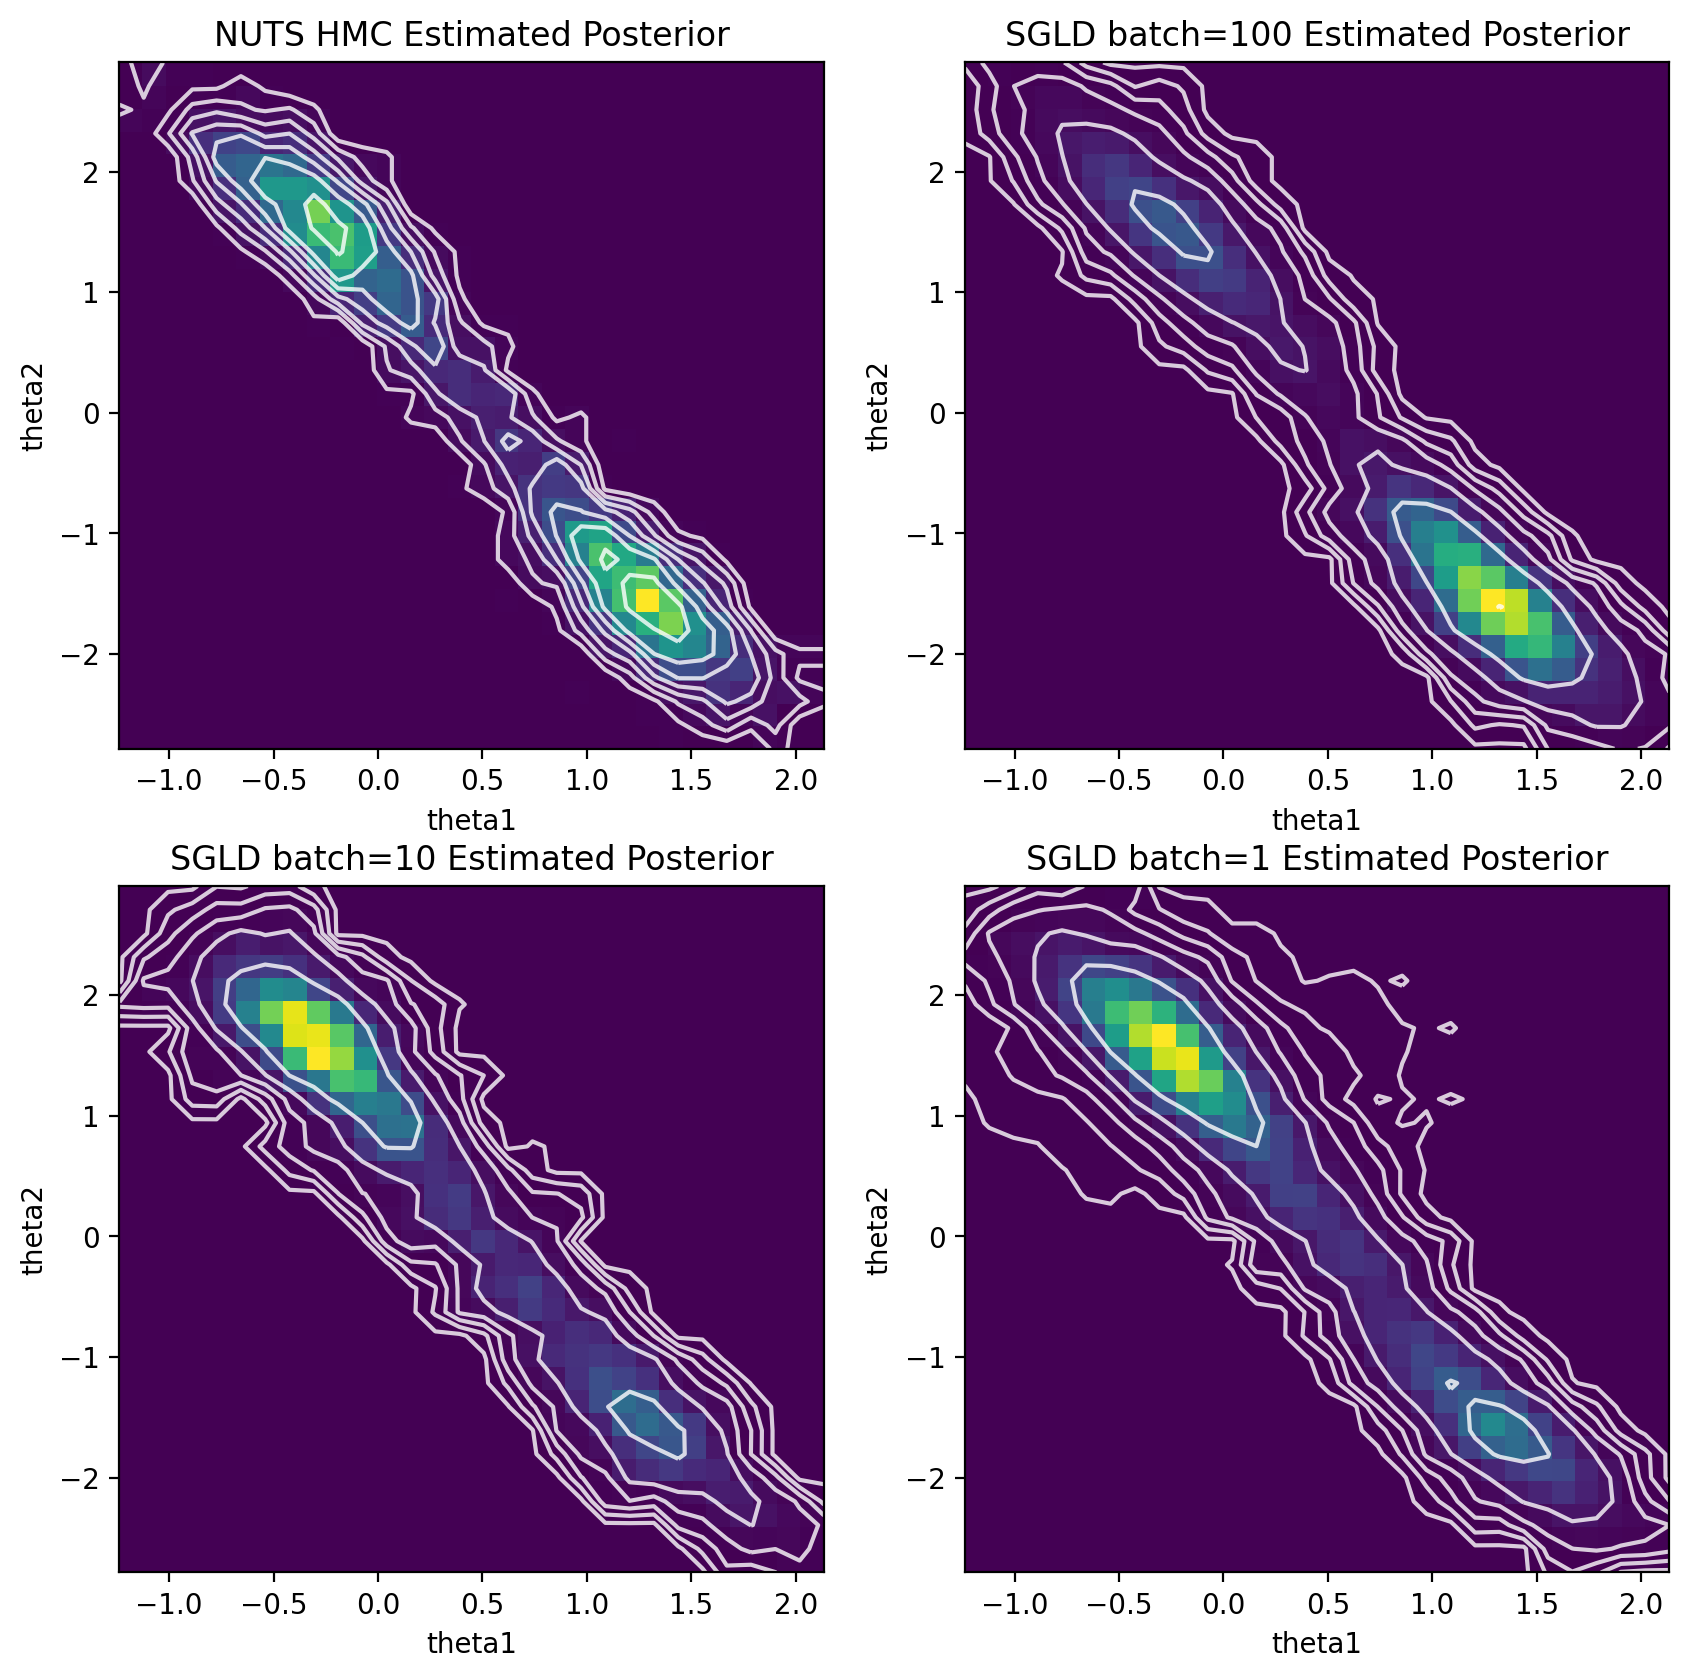

In [22]:
figure, axis = plt.subplots(2, 2, figsize=(10, 10), dpi=200)

X, Y = df_mcmc.transpose().values
X, Y
ax = axis[0, 0]
h, xs, ys, _ = ax.hist2d(X, Y, bins=[30, 30])
ax.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
            colors='white', alpha=0.8)
ax.set_title('NUTS HMC Estimated Posterior')
ax.set_xlabel('theta1')
ax.set_ylabel('theta2')
    
    
for i, batch_size in enumerate([100, 10, 1], start=1):
    df = df_sgld[batch_size]
    X, Y = df[['theta1', 'theta2']].transpose().values
    X, Y
    ax = axis[i // 2, i % 2]
    h, _, _, _ = ax.hist2d(X, Y, bins=[30, 30], range=[[xs.min(), xs.max()], [ys.min(), ys.max()]])
    ax.contour(np.log(h + 3).T, extent=[xs.min(), xs.max(), ys.min(), ys.max()],
               colors='white', alpha=0.8)
    ax.set_title(f'SGLD batch={batch_size} Estimated Posterior')
    ax.set_xlabel('theta1')
    ax.set_ylabel('theta2')

In [23]:
#plt.figure(figsize=(8, 8), dpi=100)
#plt.xlim(*xlim)
#plt.ylim(*ylim)
#plt.contour(grid[:, :, 0], grid[:, :, 1], posterior, 
#            extent=xlim+ylim, 
#            levels=50)
#plt.title('Exact posterior density of mixture model')
#plt.xlabel('theta1')
#plt.ylabel('theta2')
#plt.plot(df_sgld['theta1'].mean(), df_sgld['theta2'].mean(), 'ro') 
#plt.tight_layout()

# Notes

## 2022-10-06

* Set number of epochs to always 10k * batch_size, so that each case would always have the same number of gradient updates (i.e. the total number of mini-batches run is constant).  
* Results vary:
   * The smaller mini-batches seem to travel best between the modes, probably because the gradients are more noisy and can travel father
   * I was able to get 2 modes with batch_size = 100 at one point, but this run didn't
   * Approximation is still off from NUTS sampler and the exact calculation


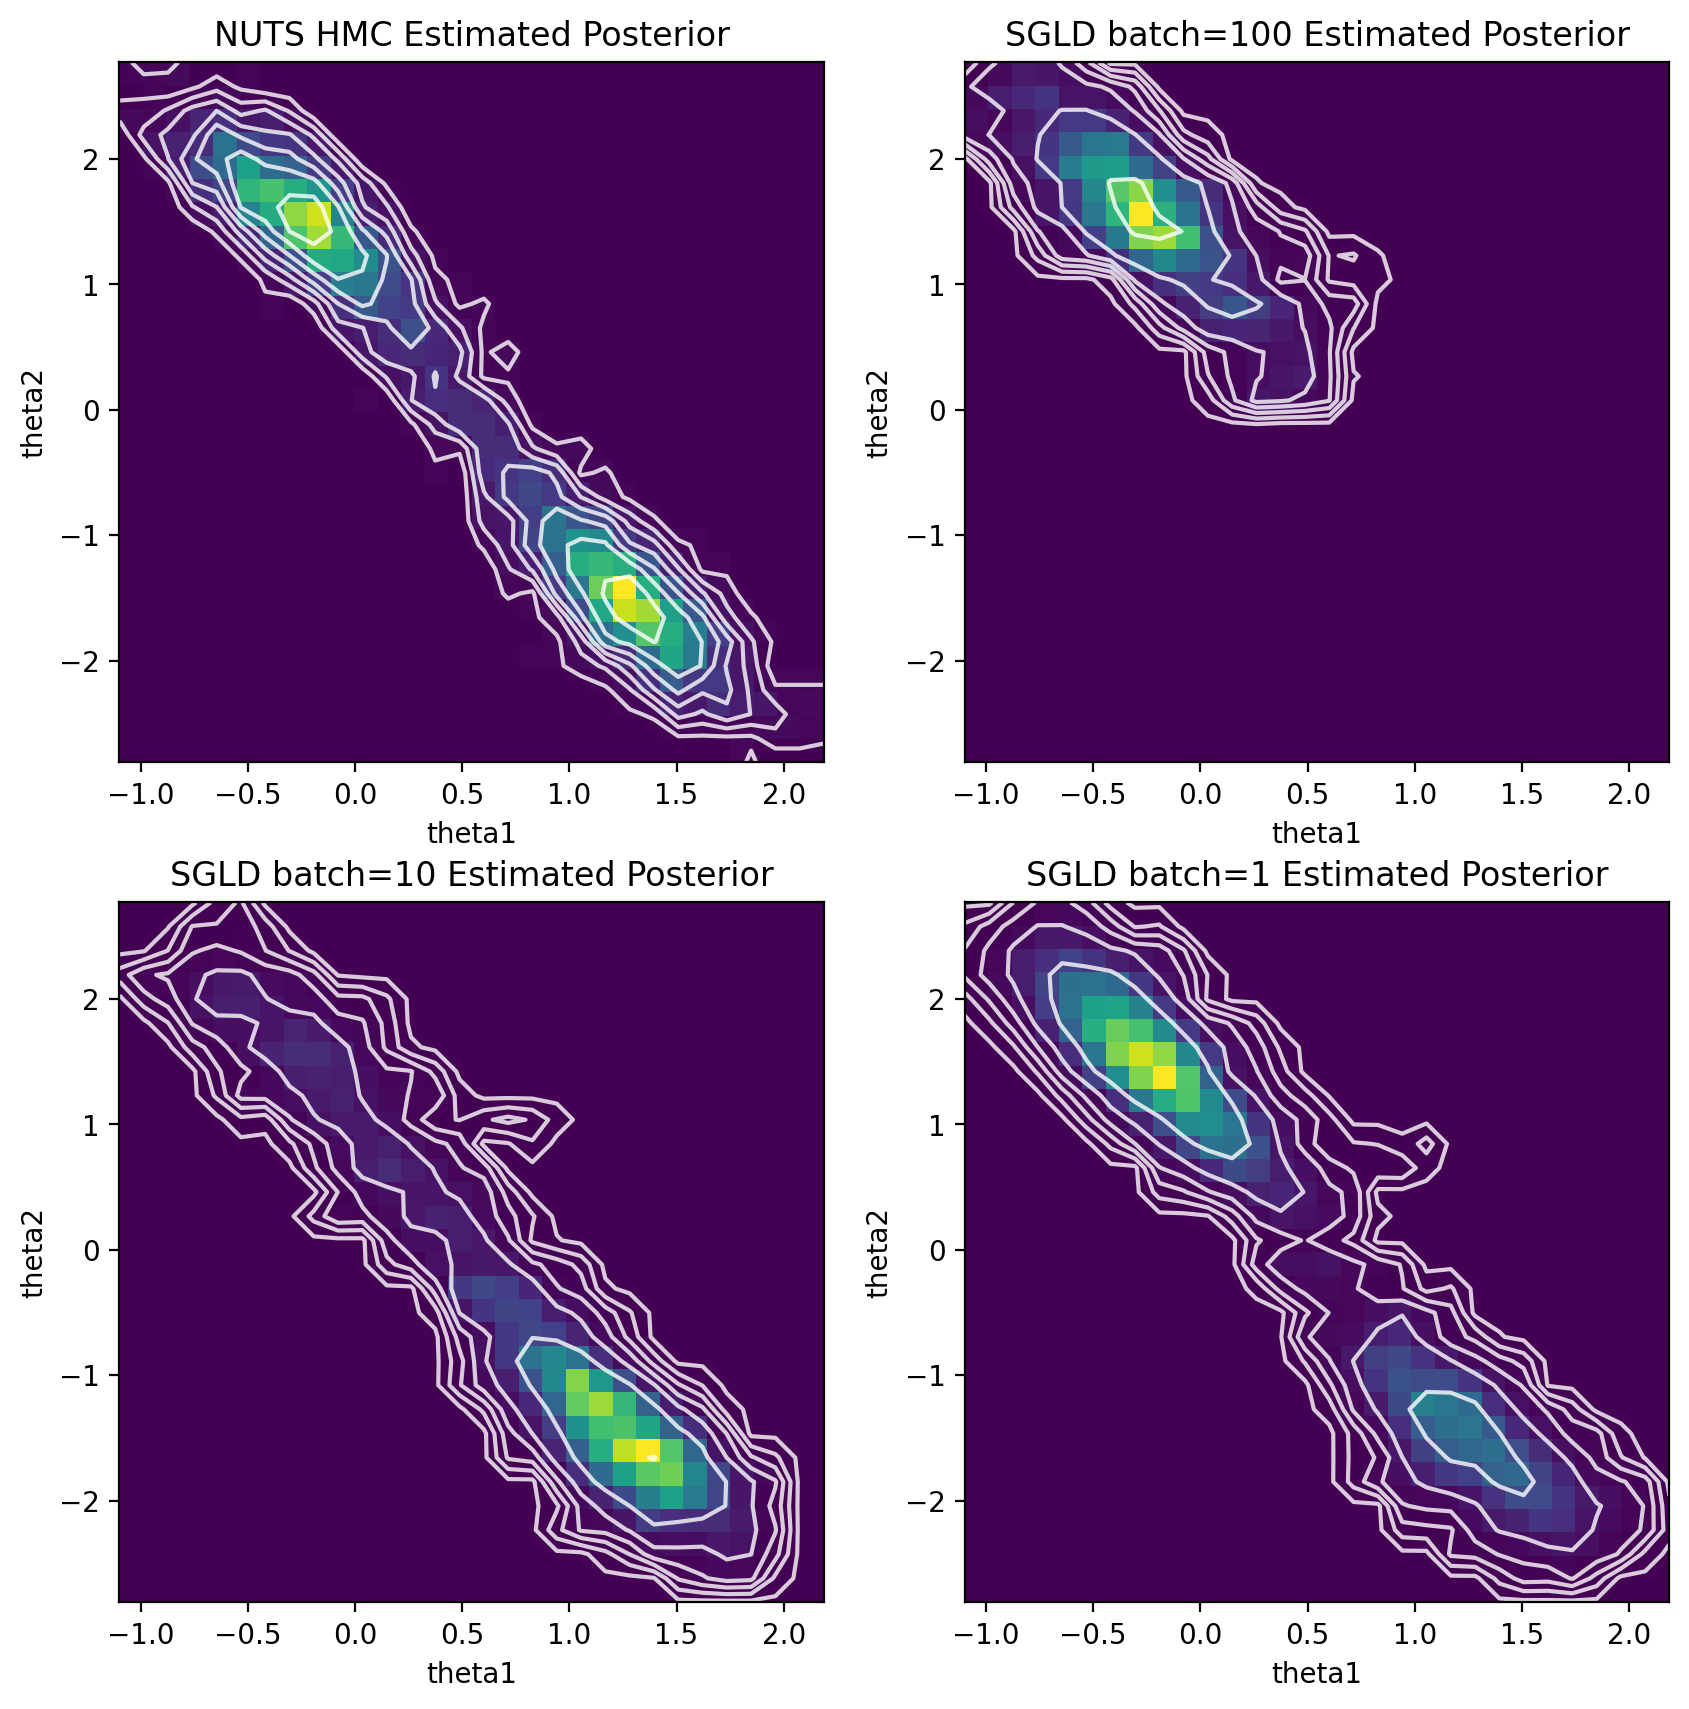

## 2022-10-05

* Looks like SGLD *sort of* works.  It found both modes but spent more time in the smaller mode.  I suppose that it would have trouble switching between modes when $\epsilon$ is small.
* I also had to decrease batch size to 1 (from 10) in order to clearly get 2 modes.  Perhaps when the batch size is too big, the gradient is too stable and not able to jump to the second mode (even with the added noise) -- needs more testing.

## 2022-10-04

* Fixed exact solution, just had a typo and needed to re-run
* Fixed another bug in SGD where my loss was not properly sizing likelihood vs. prior (N/batch_size vs. 1)
* Now all the MAP estimate is squarely in the centre of the countour plot maximum

TODO:

* Need to fix SGLD code to update each parameter separately (at least that's what I think the problem is) need to check.

## 2022-10-02

* Figured out what was wrong with SGD: I needed to use a the logpdf of a mixture distribution, NOT $N(0.5 *\theta_1 + 0.5 (\theta_1 + \theta_2), \sigma^2_x)$
* Took me a while to figure out how to use use `torch.distributions.Mixture` main bug was that I was using `torch.tensor([theta1, theta1 + theta2], requires_grad=True)` instead of `torch.cat([torch.unsqueeze(theta1, 0), torch.unsqueeze(theta1+theta2, 0)]`.  The difference is that former creates a new tensor and copies over data (so no lineage to parameters in the computation graph) vs. concat that keeps the lineage.  Additionally, I need to unsqueeze so that cat knows how to deal with tensors vs. scalars.
    * Lots of annoying stuff because I'm not that familiar with PyTorch
* Now problem is that I get something NUTS sample and SGD agree on the MAP estimate, but my "exact" solution doesn't.

TODO:
* Debug "exact" solution to make the contour plot line up with the other two

## 2022-10-01

* Modified data generation so that I actually get a multi-modal distribution by using x_std = 1.6 (vs. x_std=sqrt(2) like the paper says 
    * They must have had a pretty good random seed in order to get a multi-modal distribution, which I can often get with 1.5 but not sqrt(2)
* Made a mistake before relating posterior mean to MAP estimate, which are different.  HMC now more faithfully reproduces the multimodal distribution (approximately)
* But now SGD is quite off.  Theoretically, it should produce something close to the MAP estimate, but it produces something much smaller (with $\theta_2\approx 0$), I narrowed it down to the $\theta_2$ prior with the $\sigma_2^2=1$ makes it so that SGD seems to bind it very close to 0.  
    * Either by widening the variance or decreasing emphasis, I can get it closer to what I think the MAP estimate should be, but it's strange it does this.
    
TODO:
* Investigate why $\theta_2$ prior is pulling it so hard towards 0.
* IDEA: Try to implement the loss function myself instead of using `gaussian_nll_loss`

## 2022-09-30

* Had a bug in the "exact" calculation, now it's lining up with my SGLD much more closely
* HMC mean is strangely not that close to the center
    
TODO:
* Strangely enough, HMC is still kind of far off -- I should probably double check it
* Adjust samples by $\epsilon$ as described in the paper

## 2022-09-29

* Due to the high correlation at the tailend, so we don't get a perfect sample of the distribution like in HMC from the paper 
    * `the simple sample average will over-emphasize the tail end of the sequence where there is higher correlation among the samples, resulting in a higher variance estimator.`
    * `Measuring the sampling threshold will only beimportant if one needs to faithfully represent the posterior distribution with a finite collection of samples`
    
    
TODO:

* Adjust samples by $\epsilon$ as described in the paper
* Play around with lower noise threhold